# Notebook for generating Figures 1, 2 and 8 in Traill et al. (2025) 

Process Satellite OC-CCI NPP Data and Environmental Variables



Christopher Traill: christopher.traill@utas.edu.au

https://github.com/cdtraill

November 2025

Latest update: 11th December 2025

## Readme 

The code presented here can be simply adapated to any ocean region by changing the spatial domain. Note that in regions where the subtropical front doesn't occur, derviations of the subtropical front will drop out and potentially cause code errors. These sections can be easily omitted by commenting out sections. 

For Figures 2 and 8, there are options to sequentially or parallel process data for faster processing. Note that in Figure 2, because the bootstrapping function is an iterative calculation, that in order to parallelize i've just made the function pickable over each unique NPP product by assigning workers to cores. This is CPU heavy. In Figure 8, I've used Dask with parallelizes over chunks and is more efficient that core assignment. 

## Data sets: 

Remote sensing time series data for the period 1998-2022 were compiled to assess variability and trends in physical drivers (SST, MLD and STF locations) and NPP (Figure 4.1). Physical environmental variables of 3-dimensional gridded temperature, salinity and mixed layer depth (MLD) (Table 4.1 in manuscript) were sourced from the Copernicus Marine Service Multi Observation Global Ocean ARMOR-3D L4 analysis product. This observation-based product combines in situ temperature and salinity profiles (predominantly Argo network) with synthetic satellite sea surface temperature and altimetry derived salinity fields using an optimal interpolation method (Guinehut et al., 2012). https://data.marine.copernicus.eu/product/MULTIOBS_GLO_PHY_TSUV_3D_MYNRT_015_012/description


Estimates of NPP from five remote sensing algorithms were obtained from the OC-CCI-based dataset processed by (Ryan-Keogh et al., 2023a): the Vertical Generalized Production Model (VGPM; Behrenfeld and Falkowski (1997)), the Eppley-VGPM which includes the Eppley temperature dependent growth parameterisation (eVGPM; Eppley (1972)), the Carbon-based Production Model (CbPM; Westberry et al. (2008)), Carbon, Absorption, and Fluorescence Euphotic-resolving model (CAFE; Silsbe et al. (2016)), and Absorption-based Production Model (AbPM; Lee et al. (2011)). Detailed discussion on the algorithm input dependencies and assessment is given in Figure 4.2, Ryan-Keogh et al. (2023a) and Ryan-Keogh et al. (2025b). 

Datasets can be found in the references below (T. Ryan-Keogh's Zenodo repositories). 


References: 
- Ryan-Keogh, T. J., Thomalla, S. J., Chang, N., & Moalusi, T. (2023a). A new global oceanic multi-model net primary productivity data product. Earth System Science Data, 15(11), 4829-4848. https://doi.org/10.5194/essd-15-4829-2023 
- Ryan-Keogh, T., Thomalla, S., Chang, N., & Moalusi, T. (2025a). Net primary production from the Eppley-VGPM, Behrenfeld-VGPM, Behrenfeld-CbPM, Westberry-CbPM and Silsbe-CAFE algorithms (1.3) Zenodo. https://doi.org/10.5281/zenodo.14999403
- Ryan-Keogh, T. J., Tagliabue, A., & Thomalla, S. J. (2025b). Global decline in net primary production underestimated by climate models. Commun Earth Environ, 6(1), 75. https://doi.org/10.1038/s43247-025-02051-4
- Guinehut, S., Dhomps, A. L., Larnicol, G., & Le Traon, P. Y. (2012). High resolution 3-D temperature and salinity fields derived from in situ and satellite observations. Ocean Science, 8(5), 845-857. https://doi.org/10.5194/os-8-845-2012
- Eppley, R. W. (1972). Temperature and phytoplankton growth in the sea. Fishery bulletin, 70(4), 1063.
- Behrenfeld, M. J., & Falkowski, P. G. (1997). Photosynthetic rates derived from satellite-based chlorophyll concentration. Limnology and Oceanography, 42(1), 1-20. https://doi.org/10.4319/lo.1997.42.1.0001
- Lee, Z., Lance, V. P., Shang, S., Vaillancourt, R., Freeman, S., Lubac, B., Hargreaves, B. R., Del Castillo, C., Miller, R., Twardowski, M., & Wei, G. (2011). An assessment of optical properties and primary production derived from remote sensing in the Southern Ocean (SO GasEx). Journal of Geophysical Research, 116.
- Silsbe, G. M., Behrenfeld, M. J., Halsey, K. H., Milligan, A. J., & Westberry, T. K. (2016). The CAFE model: A net production model for global ocean phytoplankton. Global Biogeochemical Cycles, 30(12), 1756-1777. https://doi.org/10.1002/2016gb005521
- Westberry, T., Behrenfeld, M. J., Siegel, D. A., & Boss, E. (2008). Carbon-based primary productivity modeling with vertically resolved photoacclimation. Global Biogeochemical Cycles, 22(2), n/a-n/a. https://doi.org/10.1029/2007gb003078

## Dependencies and workspace configuration

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm
import matplotlib.cm as cm
from matplotlib.dates import DateFormatter
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
from scipy import stats
from scipy.stats import linregress
import pandas as pd 
import cartopy
from geopy.distance import geodesic
from geopy import Point
import gsw
import cartopy.crs as ccrs 
import cartopy.feature as cfeature 
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import netCDF4 as nc
import xarray as xr
import owslib
import os
import cftime
import sys
import glob
import calendar
import string
from tqdm import tqdm

Check environment

In [2]:
## Check environment and Set required path to data file. 
conda_env = os.environ.get("CONDA_DEFAULT_ENV")
print(f"Default conda environment: {conda_env}")
print("Actual active environment = Python executable:", sys.executable)
print("Python version:", sys.version)

Default conda environment: base
Actual active environment = Python executable: /Users/christoph/opt/anaconda3/envs/Analysis/bin/python
Python version: 3.10.18 (main, Jun  5 2025, 08:13:51) [Clang 14.0.6 ]


### Set directory path

In [3]:
path = '/Users/christoph/OneDrive - University of Tasmania/Research/PhD Project/Theme 3 Model Obs/' ## change your path here. 
os.chdir(path)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/christoph/Library/CloudStorage/OneDrive-UniversityofTasmania/Research/PhD Project/Theme 3 Model Obs


# Load and pre-process datasets

## Set analysis spatial domain

In [4]:
lon_min, lon_max = 140, 150
lat_min, lat_max = -49, -45

## Copernicus ARMOR 3D Ocean physics: T, S and MLD
The best way to obtain CMS products is using subset tools in the CMS toolbox. For new users, I have a notebook here that provides easy implemntation (new people will need to sign up to Copernicus). See https://github.com/cdtraill/Copernicus-Marine-Service-product-access-and-plotting


In [5]:
# Load dataset
tsmld_nc = xr.open_dataset('CMS ARMOR 3D TSMLD Product/ARMOR_3D_L4_TSMLD_Monthly_REP_120E_160E_60S_35S_0_1000m.nc')

# Extract month and year from the datetime64 'time' coordinate
months = tsmld_nc['time'].dt.month
years = tsmld_nc['time'].dt.year

# Apply July-year logic to centre years on January later on. 
july_year = xr.DataArray(
    years.where(months >= 7, years - 1),
    coords={"time": tsmld_nc.time},
    dims="time",
    name="july_year"
)

# Assign as a coordinate to the dataset
tsmld_nc = tsmld_nc.assign_coords(july_year=july_year, month = months)

In [6]:
tsmld_nc_subset = tsmld_nc.sel(latitude = slice(lat_min, lat_max), longitude = slice(lon_min, lon_max), time=slice('1998-01-01', None))

## Derive Subtropical Front (STF) locations at every longitude in the subset domain. 
Based on the 11°C Isotherm at 100 dbar (Orsi et al. 1995). 

In [7]:
subset_latmin, subset_latmax, subset_lonmin, subset_lonmax = min(tsmld_nc_subset['latitude'].values), max(tsmld_nc_subset['latitude'].values),min(tsmld_nc_subset['longitude'].values), max(tsmld_nc_subset['longitude'].values)
print(f'Spatial subset extent: {subset_latmin, subset_latmax, subset_lonmin, subset_lonmax }')

# Extract varaibles (temperature, lat, lon, time) at depth level
temp_100 = tsmld_nc_subset.sel(depth=100)

temp = temp_100['to']
lat = temp_100['latitude']
lon = temp_100['longitude']
time = temp_100['time']

# Get unique year-month pairs from the time dimension
year_months = np.array([(t.dt.year.item(), t.dt.month.item()) for t in time])
unique_years = np.unique([ym[0] for ym in year_months])

# DataFrame to store results
df_list = []

# Loop over each unique year
for year in unique_years:
    print(f"Processing {year}...")

    # Get all unique months in this year
    months_in_year = np.unique([m for (y, m) in year_months if y == year])

    for month in months_in_year:
        # Create mask and subset using .where(..., drop=True)
        mask = (time.dt.year == year) & (time.dt.month == month)
        temp_month = temp_100.where(mask, drop=True)

        if temp_month.time.size == 0:
            print(f"No data for {year}-{month:02d}, skipping...")
            continue

        # Store longitude-latitude pairs for all time steps in this month
        lon_list = []
        lat_list = []

        # Keep track of timesteps with no contours
        no_contour_timesteps = []

        # Extract 11°C contour data
        for i in range(len(temp_month.time)):
            try:
                cs = plt.contour(lon, lat, temp_month['to'].isel(time=i), levels=[11.0])
                
                # Debug: show number of segments per level
#                print(f"time {i}: allsegs = {[len(segs) for segs in cs.allsegs]}")

                found = False
                for segs in cs.allsegs:        # each contour level
                    for seg in segs:           # each continuous line segment
                        if seg.shape[0] > 1:   # only consider non-degenerate paths
                            lon_list.append(seg[:, 0])
                            lat_list.append(seg[:, 1])
                            found = True

                if not found:
                    no_contour_timesteps.append(i)

                plt.close()

            except ValueError:
                print(f"Skipping time index {i} for {year}-{month:02d}: No valid contour found")
                no_contour_timesteps.append(i)

        if len(lon_list) == 0 or len(lat_list) == 0:
#            print(f"No contours detected for {year}-{month:02d}, skipping...")
#            print(f"Timesteps with no contours: {no_contour_timesteps}")
            continue
        else:
            if no_contour_timesteps:
                print(f"Timesteps with no contours for {year}-{month:02d}: {no_contour_timesteps}")

        # Process contour points
        all_lons = np.concatenate(lon_list)
        all_lats = np.concatenate(lat_list)

        sort_idx = np.argsort(all_lons)
        sorted_lons = all_lons[sort_idx]
        sorted_lats = all_lats[sort_idx]

        unique_lons = np.linspace(sorted_lons.min(), sorted_lons.max(), num=30)  # Stf latitudes are interpolated onto a regular long grid to smooth the contours. 
        mean_lats = []

        for lon_val in unique_lons:
            bin_mask = np.abs(sorted_lons - lon_val) < 0.5
            if np.any(bin_mask):
                mean_lats.append(np.mean(sorted_lats[bin_mask]))
            else:
                mean_lats.append(np.nan)

        mean_lats = np.array(mean_lats)

        # Interpolate missing values
        valid = ~np.isnan(mean_lats)
        if np.any(valid):
            interp_mean = interp1d(unique_lons[valid], mean_lats[valid], kind='linear', fill_value='extrapolate')
            mean_lats = interp_mean(unique_lons)

        df_month = pd.DataFrame({
            'year': year,
            'month': month,
            'longitude': unique_lons,
            'mean_latitude': mean_lats
        })

        df_list.append(df_month)


# Concatenate results
df_monthly_stf = pd.concat(df_list, ignore_index=True)

print("Dataframe of monthly STF latitudes at every longitude compiled: df_monthly_stf")

Spatial subset extent: (np.float32(-48.875), np.float32(-45.125), np.float32(140.125), np.float32(149.875))
Processing 1998...
Processing 1999...
Processing 2000...
Processing 2001...
Processing 2002...
Processing 2003...
Processing 2004...
Processing 2005...
Processing 2006...
Processing 2007...
Processing 2008...
Processing 2009...
Processing 2010...
Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...
Processing 2019...
Processing 2020...
Processing 2021...
Processing 2022...
Dataframe of monthly STF latitudes at every longitude compiled: df_monthly_stf


In [8]:
# Trim time series of monthly STF
#df_monthly_stf_subset = df_monthly_stf[df_monthly_stf['year'] >= 2002]
df_monthly_stf_subset = df_monthly_stf

# Earth radius in meters
R = 6.371e6

# Convert degrees to radians
def deg2rad(deg):
    return np.radians(deg)

# Calculate surface area (approx) between lat1 and lat2 over lon width
def area_between(lat1, lat2, lon_width_deg):
    """
    Returns area between two latitudes over given longitude width (in degrees).
    """
    lat1_rad = deg2rad(lat1)
    lat2_rad = deg2rad(lat2)
    lon_width_rad = deg2rad(lon_width_deg)
    
    return R**2 * np.abs(np.sin(lat2_rad) - np.sin(lat1_rad)) * lon_width_rad

# Group by time
df_monthly_stf_subset['timestep'] = df_monthly_stf_subset['year'] * 100 + df_monthly_stf_subset['month']
results = []

for timestep, group in df_monthly_stf_subset.groupby('timestep'):
    group = group.sort_values('longitude')
    
    # Only consider longitudes inside the box
    box_group = group[(group['longitude'] >= lon_min) & (group['longitude'] <= lon_max)].copy()
    
    if box_group.empty:
        results.append({
            'timestep': timestep,
            'year': group['year'].iloc[0],
            'month': group['month'].iloc[0],
            'percent_covered': np.nan,
            'mean_latitude': np.nan
        })
        continue
    
    # Clip STF latitude to within box (for partial coverage)
    box_group['stf_clipped'] = np.clip(box_group['mean_latitude'], lat_min, lat_max)
    
    # Estimate area north of STF at each longitude
    lon_vals = box_group['longitude'].values
    lat_vals = box_group['stf_clipped'].values
    
    # Compute longitude intervals (assumes regular spacing)
    dlon = np.mean(np.diff(lon_vals)) if len(lon_vals) > 1 else (lon_max - lon_min)
    
    # Compute area north of STF at each longitude
    covered_areas = [
        area_between(lat, lat_max, dlon) for lat in lat_vals
    ]
    
    # Total STF-covered area (north of STF within box)
    total_covered_area = np.nansum(covered_areas)
    
    # Total area of the full box
    total_box_area = area_between(lat_min, lat_max, lon_max - lon_min)
    
    percent_covered = (total_covered_area / total_box_area) * 100
    mean_latitude = box_group['mean_latitude'].mean()

    results.append({
        'timestep': timestep,
        'year': group['year'].iloc[0],
        'month': group['month'].iloc[0],
        'percent_covered': percent_covered,
        'mean_latitude': mean_latitude
    })

df_area_coverage = pd.DataFrame(results)
df_area_coverage['july_year'] = df_area_coverage.apply(
    lambda row: row['year'] if row['month'] >= 7 else row['year'] - 1, axis=1
)

print(f"Finished monthly STF areal coverage in SOTS region {lon_min, lon_max} E")

Finished monthly STF areal coverage in SOTS region (140, 150) E


## Climatological MLD, SST and SSS (ARMOR-3D Obs) for the subsetted region

### Subset to desired region by slicing lat and lon

In [9]:
# Define weights based on cosine of latitude
weights_mld_sst = np.cos(np.deg2rad(tsmld_nc_subset.latitude))
weights_mld_sst.name = "weights_mld_sst"

# calculate climatological surface temp, salinity and MLD
tsmld_spatial_avg = tsmld_nc_subset.sel(depth = 0).weighted(weights_mld_sst).mean(dim=["latitude", "longitude"])
tsmld_spatial_avg_clim = tsmld_nc_subset.sel(depth = 0).groupby("time.month").mean(dim=["time","latitude", "longitude"])
tsmld_spatial_std_clim = tsmld_nc_subset.sel(depth = 0).groupby("time.month").std(dim=["time","latitude", "longitude"])

tsmld_temporal_avg_clim = tsmld_spatial_avg.groupby("time.month").mean(dim=["time"])
tsmld_temporal_std_clim = tsmld_spatial_avg.groupby("time.month").std(dim=["time"])

tsmld_climatology = xr.Dataset({
    "month": tsmld_spatial_avg_clim['month'],
    "mld_mean": tsmld_temporal_avg_clim['mlotst'],
    "mld_std": tsmld_temporal_std_clim['mlotst'],
    "sst_mean": tsmld_temporal_avg_clim['to'],
    "sst_std": tsmld_temporal_std_clim['to'],
    "sal_mean": tsmld_temporal_avg_clim['so'],
    "sal_std": tsmld_temporal_std_clim['so']
})

## Hadley MLD product

From Tommy Ryan-Keogh. MLD dervied from the Gouretski and Reseghetii (2010) profiles using a density threshold o f0.03 kg m-3 (de Boyer Montegut et al. 2004). 

(EN.4.2.2.profiles.g10.####.zip). 
 
Method to derive MLD from Hadley profiles: 
Calculated density from the temperature and salinity profiles using the gsw package. Determined the MLD depth using a criterion of 0.03 and then interpolated this grid from 1 degree to a 25km grid and from monthly to 8 day resolution.

In [10]:
hadley_mld_nc = xr.open_dataset('Hadley MLD Product/HADLEY_EN422_MLD_8D_25KM_1998_2024.nc')

# Extract month and year from the datetime64 'time' coordinate
months = hadley_mld_nc['time'].dt.month
years = hadley_mld_nc['time'].dt.year

# Apply July-year logic to centre years on January later on. 
july_year = xr.DataArray(
    years.where(months >= 7, years - 1),
    coords={"time": hadley_mld_nc.time},
    dims="time",
    name="july_year"
)

# Assign as a coordinate to the dataset
hadley_mld_nc = hadley_mld_nc.assign_coords(july_year=july_year)

In [11]:
hadley_mld_nc_subset = hadley_mld_nc.sel(lat = slice(lat_min, lat_max), lon = slice(lon_min, lon_max), time=slice('1998-01-01', '2022-12-31'))

# rename lat and lon to latitude and longitude for consistency with boostrapping algortithms
hadley_mld_nc_subset = hadley_mld_nc_subset.rename({'lat': 'latitude', 'lon': 'longitude'})

# resample to monthly temporal resolution for bootstrapping later
hadley_mld_nc_subset_monthly = hadley_mld_nc_subset.resample(time='1M').mean()

# reassign july-year which was removed in monthly resampling
# Extract month and year from the datetime64 'time' coordinate
months = hadley_mld_nc_subset_monthly['time'].dt.month
years = hadley_mld_nc_subset_monthly['time'].dt.year

# Apply July-year logic to centre years on January later on. 
july_year = xr.DataArray(
    years.where(months >= 7, years - 1),
    coords={"time": hadley_mld_nc_subset_monthly.time},
    dims="time",
    name="july_year"
)

# This dataset is needed for later boostrap analysis. 
hadley_mld_nc_subset_monthly = hadley_mld_nc_subset_monthly.assign_coords(july_year=july_year, month = months)

/Users/christoph/opt/anaconda3/envs/Analysis/lib/python3.10/site-packages/xarray/groupers.py:498: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [12]:
# Determine climatological MLD
# Define weights based on cosine of latitude to scale MLD values across grid cells of difference size. 
weights_hadley_mld = np.cos(np.deg2rad(hadley_mld_nc_subset.latitude))
weights_hadley_mld.name = "weights_hadley_mld"

# Spatial averages
hadley_mld_spatial_avg = hadley_mld_nc_subset.weighted(weights_hadley_mld).mean(dim=["latitude", "longitude"])

# Temporal averages of the wrighted spatial mean. 
hadley_mld_temporal_avg_clim = hadley_mld_spatial_avg.groupby("time.month").mean(dim=["time"])
hadley_mld_temporal_std_clim = hadley_mld_spatial_avg.groupby("time.month").std(dim=["time"])

hadley_mld_climatology = xr.Dataset({
    "month": hadley_mld_temporal_avg_clim['month'],
    "mld_mean": hadley_mld_temporal_avg_clim['mld'],
    "mld_std": hadley_mld_temporal_std_clim['mld']
})

## Load and process OC-CCI NPP products

In [13]:
# Load and subset datasets, then remove full domains to reduce memory load
NPP_VGPM_OCCCI = xr.open_dataset('OC_CCI_NPP_algorithms/1998_2024_NPP_BEHRENFELD_VGPM_25KM_8D.nc') # make sure Path is correct! 
NPP_VGPM_OCCCI_subset = NPP_VGPM_OCCCI.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max), time=slice('1997-07-01', "2023-06-30"))

# Calculate grid cel areas for weighting: 
# constants
R = 6371e3  # Earth's radius in meters

# get grid spacing
dlat = np.abs(np.diff(NPP_VGPM_OCCCI_subset.lat).mean())
dlon = np.abs(np.diff(NPP_VGPM_OCCCI_subset.lon).mean())

# convert to radians
dlat_rad = np.deg2rad(dlat)
dlon_rad = np.deg2rad(dlon)

# compute gridcell area as function of latitude
lat_rad = np.deg2rad(NPP_VGPM_OCCCI_subset.lat)
cell_areas = (R**2) * dlat_rad * dlon_rad * np.cos(lat_rad)

# put into an xarray DataArray for convenience
area_da = xr.DataArray(
    cell_areas,
    coords={'lat': NPP_VGPM_OCCCI_subset.lat},
    dims=['lat'],
    name='cell_area'
)

NPP_VGPM_OCCCI.close()
del NPP_VGPM_OCCCI

NPP_eVGPM_OCCCI = xr.open_dataset('OC_CCI_NPP_algorithms/1998_2024_NPP_EPPLEY_VGPM_25KM_8D.nc')
NPP_eVGPM_OCCCI_subset = NPP_eVGPM_OCCCI.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max), time=slice('1997-07-01', "2023-06-30"))
NPP_eVGPM_OCCCI.close()
del NPP_eVGPM_OCCCI

NPP_CAFE_OCCCI = xr.open_dataset('OC_CCI_NPP_algorithms/1998_2024_NPP_SILSBE_CAFE_25KM_8D.nc')
NPP_CAFE_OCCCI_subset = NPP_CAFE_OCCCI.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max), time=slice('1997-07-01', "2023-06-30"))
NPP_CAFE_OCCCI.close()
del NPP_CAFE_OCCCI

NPP_CbPM_OCCCI = xr.open_dataset('OC_CCI_NPP_algorithms/1998_2024_NPP_WESTBERRY_CBPM_25KM_8D.nc')
NPP_CbPM_OCCCI_subset = NPP_CbPM_OCCCI.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max), time=slice('1997-07-01', "2023-06-30"))
NPP_CbPM_OCCCI.close()
del NPP_CbPM_OCCCI

NPP_AbPM_OCCCI = xr.open_dataset('OC_CCI_NPP_algorithms/1998_2024_NPP_LEE_ABPM_25KM_8D.nc')
NPP_AbPM_OCCCI_subset = NPP_AbPM_OCCCI.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max), time=slice('1997-07-01', "2023-06-30"))
NPP_AbPM_OCCCI.close()
del NPP_AbPM_OCCCI

print('Grid area weights calcualted and stored as an array: area_da')
print('Subsetting complete, full domains removed from memory')



Grid area weights calcualted and stored as an array: area_da
Subsetting complete, full domains removed from memory


In [14]:
# Build a coordinate of January-centered (July to June) year indices and add to dataframes
cbpm_years = NPP_CbPM_OCCCI_subset['time.year'].values
cbpm_months = NPP_CbPM_OCCCI_subset['time.month'].values 

evgpm_years = NPP_eVGPM_OCCCI_subset['time.year'].values
evgpm_months = NPP_eVGPM_OCCCI_subset['time.month'].values 

cafe_years = NPP_CAFE_OCCCI_subset['time.year'].values
cafe_months = NPP_CAFE_OCCCI_subset['time.month'].values 

vgpm_years = NPP_VGPM_OCCCI_subset['time.year'].values
vgpm_months = NPP_VGPM_OCCCI_subset['time.month'].values 

abpm_years = NPP_AbPM_OCCCI_subset['time.year'].values
abpm_months = NPP_AbPM_OCCCI_subset['time.month'].values 

# Use the time dimension to construct the 1D july_year array
july_year_cbpm = xr.where(NPP_CbPM_OCCCI_subset['time.month'] >= 7,
                          NPP_CbPM_OCCCI_subset['time.year'],
                          NPP_CbPM_OCCCI_subset['time.year'] - 1)

july_year_evgpm = xr.where(NPP_eVGPM_OCCCI_subset['time.month'] >= 7,
                          NPP_eVGPM_OCCCI_subset['time.year'],
                          NPP_eVGPM_OCCCI_subset['time.year'] - 1)

july_year_cafe = xr.where(NPP_CAFE_OCCCI_subset['time.month'] >= 7,
                          NPP_CAFE_OCCCI_subset['time.year'],
                          NPP_CAFE_OCCCI_subset['time.year'] - 1)

july_year_vgpm = xr.where(NPP_VGPM_OCCCI_subset['time.month'] >= 7,
                          NPP_VGPM_OCCCI_subset['time.year'],
                          NPP_VGPM_OCCCI_subset['time.year'] - 1)

july_year_abpm = xr.where(NPP_AbPM_OCCCI_subset['time.month'] >= 7,
                          NPP_AbPM_OCCCI_subset['time.year'],
                          NPP_AbPM_OCCCI_subset['time.year'] - 1)

# Assign july_year to DataArrays as 1D coordinate
NPP_CbPM_OCCCI_subset = NPP_CbPM_OCCCI_subset.assign_coords(july_year=('time', july_year_cbpm.data))
NPP_eVGPM_OCCCI_subset = NPP_eVGPM_OCCCI_subset.assign_coords(july_year=('time', july_year_evgpm.data))
NPP_CAFE_OCCCI_subset = NPP_CAFE_OCCCI_subset.assign_coords(july_year=('time', july_year_cafe.data))
NPP_VGPM_OCCCI_subset = NPP_VGPM_OCCCI_subset.assign_coords(july_year=('time', july_year_vgpm.data))
NPP_AbPM_OCCCI_subset = NPP_AbPM_OCCCI_subset.assign_coords(july_year=('time', july_year_abpm.data))

# Average over spatial domain for monthly and january centred (july_year)-annual averages
monthly_NPP_CbPM_OCCCI_avg =  NPP_CbPM_OCCCI_subset['Westberry-CbPM'].mean(dim=['lat', 'lon']).resample(time='1MS').mean()          
monthly_NPP_CbPM_OCCCI_std = NPP_CbPM_OCCCI_subset['Westberry-CbPM'].mean(dim=['lat', 'lon']).resample(time='1MS').std()  

monthly_NPP_eVGPM_OCCCI_avg = NPP_eVGPM_OCCCI_subset['Eppley-VGPM'].mean(dim=['lat', 'lon']).resample(time='1MS').mean()   
monthly_NPP_eVGPM_OCCCI_std = NPP_eVGPM_OCCCI_subset['Eppley-VGPM'].mean(dim=['lat', 'lon']).resample(time='1MS').std() 

monthly_NPP_CAFE_OCCCI_avg = NPP_CAFE_OCCCI_subset['Silsbe-CAFE'].mean(dim=['lat', 'lon']).resample(time='1MS').mean()   
monthly_NPP_CAFE_OCCCI_std = NPP_CAFE_OCCCI_subset['Silsbe-CAFE'].mean(dim=['lat', 'lon']).resample(time='1MS').std() 

monthly_NPP_VGPM_OCCCI_avg = NPP_VGPM_OCCCI_subset['Behrenfeld-VGPM'].mean(dim=['lat', 'lon']).resample(time='1MS').mean()   
monthly_NPP_VGPM_OCCCI_std =NPP_VGPM_OCCCI_subset['Behrenfeld-VGPM'].mean(dim=['lat', 'lon']).resample(time='1MS').std() 

print('Monthly resampling of NPP products complete') 

Monthly resampling of NPP products complete


### Climatological weighted NPP calculations

In [15]:
# Define weights based on cosine of latitude
weights = np.cos(np.deg2rad(NPP_VGPM_OCCCI_subset.lat))
weights.name = "weights"

# Group by year and month, and compute the mean and standard deviation of mean_latitude
NPP_CbPM_OCCCI_spatial_avg = NPP_CbPM_OCCCI_subset['Westberry-CbPM'].weighted(weights).mean(dim=['lat', 'lon'])
NPP_CbPM_OCCCI_tempavg_clim = NPP_CbPM_OCCCI_spatial_avg.groupby('time.month').mean(dim = ['time'])
NPP_CbPM_OCCCI_tempstd_clim = NPP_CbPM_OCCCI_spatial_avg.groupby('time.month').std(dim = ['time'])
NPP_CbPM_OCCCI_tempavg = (NPP_CbPM_OCCCI_tempavg_clim.values)/12.011 
NPP_CbPM_OCCCI_tempstd = (NPP_CbPM_OCCCI_tempstd_clim.values)/12.011 
NPP_CbPM_OCCCI_tempavg_shifted = np.roll(NPP_CbPM_OCCCI_tempavg, -6)
NPP_CbPM_OCCCI_tempstd_shifted = np.roll(NPP_CbPM_OCCCI_tempstd, -6)

NPP_VGPM_OCCCI_spatial_avg = NPP_VGPM_OCCCI_subset['Behrenfeld-VGPM'].weighted(weights).mean(dim=['lat', 'lon'])
NPP_VGPM_OCCCI_tempavg_clim = NPP_VGPM_OCCCI_spatial_avg.groupby('time.month').mean(dim = ['time'])
NPP_VGPM_OCCCI_tempstd_clim = NPP_VGPM_OCCCI_spatial_avg.groupby('time.month').std(dim = ['time'])
NPP_VGPM_OCCCI_tempavg = (NPP_VGPM_OCCCI_tempavg_clim.values)/12.011
NPP_VGPM_OCCCI_tempstd = (NPP_VGPM_OCCCI_tempstd_clim.values)/12.011
NPP_VGPM_OCCCI_tempavg_shifted = np.roll(NPP_VGPM_OCCCI_tempavg, -6)
NPP_VGPM_OCCCI_tempstd_shifted = np.roll(NPP_VGPM_OCCCI_tempstd, -6)

NPP_eVGPM_OCCCI_spatial_avg = NPP_eVGPM_OCCCI_subset['Eppley-VGPM'].weighted(weights).mean(dim=['lat', 'lon'])
NPP_eVGPM_OCCCI_tempavg_clim = NPP_eVGPM_OCCCI_spatial_avg.groupby('time.month').mean(dim = ['time'])
NPP_eVGPM_OCCCI_tempstd_clim = NPP_eVGPM_OCCCI_spatial_avg.groupby('time.month').std(dim = ['time'])
NPP_eVGPM_OCCCI_tempavg = (NPP_eVGPM_OCCCI_tempavg_clim.values)/12.011
NPP_eVGPM_OCCCI_tempstd = (NPP_eVGPM_OCCCI_tempstd_clim.values)/12.011
NPP_eVGPM_OCCCI_tempavg_shifted = np.roll(NPP_eVGPM_OCCCI_tempavg, -6)
NPP_eVGPM_OCCCI_tempstd_shifted = np.roll(NPP_eVGPM_OCCCI_tempstd, -6)

NPP_CAFE_OCCCI_spatial_avg = NPP_CAFE_OCCCI_subset['Silsbe-CAFE'].weighted(weights).mean(dim=['lat', 'lon'])
NPP_CAFE_OCCCI_tempavg_clim = NPP_CAFE_OCCCI_spatial_avg.groupby('time.month').mean(dim = ['time'])
NPP_CAFE_OCCCI_tempstd_clim = NPP_CAFE_OCCCI_spatial_avg.groupby('time.month').std(dim = ['time'])
NPP_CAFE_OCCCI_tempavg = (NPP_CAFE_OCCCI_tempavg_clim.values)/12.011
NPP_CAFE_OCCCI_tempstd = (NPP_CAFE_OCCCI_tempstd_clim.values)/12.011
NPP_CAFE_OCCCI_tempavg_shifted = np.roll(NPP_CAFE_OCCCI_tempavg, -6)
NPP_CAFE_OCCCI_tempstd_shifted = np.roll(NPP_CAFE_OCCCI_tempstd, -6)

NPP_AbPM_OCCCI_spatial_avg = NPP_AbPM_OCCCI_subset['Lee-AbPM'].weighted(weights).mean(dim=['lat', 'lon'])
NPP_AbPM_OCCCI_avg_clim = NPP_AbPM_OCCCI_subset['Lee-AbPM'].groupby('time.month').mean(dim = ['lat', 'lon']) 
NPP_AbPM_OCCCI_tempavg_clim = NPP_AbPM_OCCCI_spatial_avg.groupby('time.month').mean(dim = ['time'])
NPP_AbPM_OCCCI_tempstd_clim = NPP_AbPM_OCCCI_spatial_avg.groupby('time.month').std(dim = ['time'])
NPP_AbPM_OCCCI_tempavg = (NPP_AbPM_OCCCI_tempavg_clim.values)/12.011 
NPP_AbPM_OCCCI_tempstd = (NPP_AbPM_OCCCI_tempstd_clim.values)/12.011 
NPP_AbPM_OCCCI_tempavg_shifted = np.roll(NPP_AbPM_OCCCI_tempavg, -6)
NPP_AbPM_OCCCI_tempstd_shifted = np.roll(NPP_AbPM_OCCCI_tempstd, -6)

# Figure 1: 
## 4-panel plot for Observed STF contours, STF mean, SST/MLD and NPP. 

/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_5771/718312012.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set3', 12)  # Tab12 gives 12 distinct colors
/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_5771/718312012.py:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


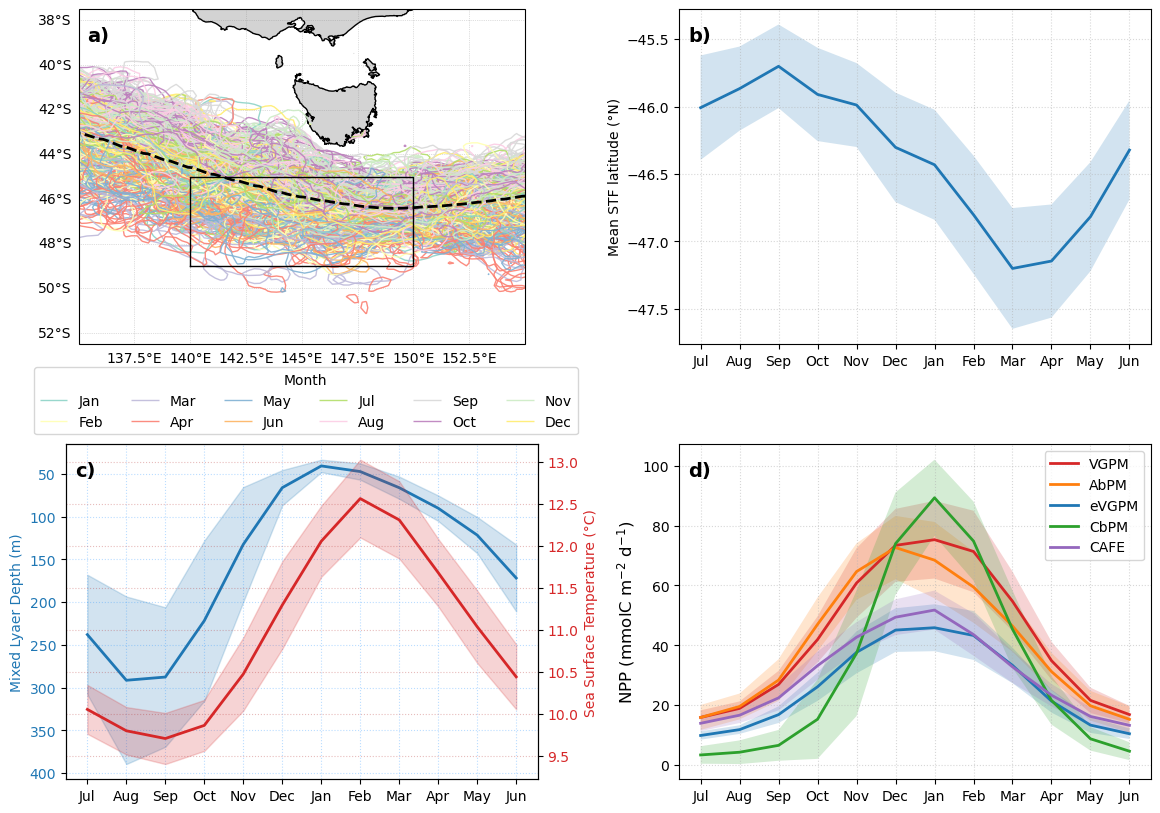

In [16]:
# Create figure
fig, axs = plt.subplots(
    2, 2,
    figsize=(14, 10),
    gridspec_kw={'hspace': 0.3, 'wspace': 0.3}
)

# Redefine just the panel that needs a projection (top-left panel here)
fig.delaxes(axs[0, 0])  # Remove the original subplot
ax1 = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
axs[0, 0] = ax1  # Replace with new axis

# Assign other axes
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]

axes_list = [ax1, ax2, ax3, ax4]
for i, ax in enumerate(axes_list):
    ax.text(
        0.02, 0.95,
        f"{string.ascii_lowercase[i]})",
        transform=ax.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top'
    )

# -------- Panel (a) STF monthly positions ARMOR-3D -------- #
# Select the depth level of 100 from tsmld_nc ARMOR-3d subset: uses full domain to plot contours outside analysis area.
temp_100 = tsmld_nc.sel(depth=100, time=slice('1998-01-01', None))

# Extract temperature, lat, lon, time
temp = temp_100['to']
lat = temp_100['latitude']
lon = temp_100['longitude']
time = temp_100['time']

# Extract month numbers (1-12)
months = np.array([t.dt.month.item() for t in time])

# Define 12 colors (one per month)
cmap = cm.get_cmap('Set3', 12)  # Tab12 gives 12 distinct colors
shift = 0
month_colors = {m: cmap(((m - 1 + shift) % 12)) for m in range(1, 13)}

ax1.set_extent([135, 155, -52.5, -37.5], crs=ccrs.PlateCarree())

# Add coastlines and features
ax1.coastlines(resolution='10m')
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle=':')
gl.top_labels = False
gl.right_labels = False

# Dictionary to store contour objects for the legend
contour_handles = {}

# Store all extracted contour points for smoothing
lon_list = []
lat_list = []

# Loop through each time step and extract 11°C contour
for i, t in enumerate(time):
    month = months[i]
    color = month_colors[month]

    # Plot contour for this time step
    cs = ax1.contour(lon, lat, temp.isel(time=i), levels=[11.0], colors=[color], linewidths=1, alpha = 0.9)

    # Store contour object for legend
    if month not in contour_handles:
        contour_handles[month] = cs.legend_elements()[0][0]

    # Extract contour points for smoothing
    for segs in cs.allsegs:        # list of all contour levels
        for seg in segs:           # each contour segment
            lon_list.append(seg[:, 0])
            lat_list.append(seg[:, 1])

# Convert extracted contour points to numpy arrays
all_lons = np.concatenate(lon_list)
all_lats = np.concatenate(lat_list)

# Sort by longitude
sort_idx = np.argsort(all_lons)
sorted_lons = all_lons[sort_idx]
sorted_lats = all_lats[sort_idx]

# Plot bounding box
ax1.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
        [lat_min, lat_min, lat_max, lat_max, lat_min],
        color='black', linestyle='-', linewidth=1, label='Bounding Box')

# Define interpolation grid for smoothing
unique_lons = np.linspace(sorted_lons.min(), sorted_lons.max(), num=200)

# Compute mean latitude per longitude bin
mean_lats = []
for lon_val in unique_lons:
    mask = np.abs(sorted_lons - lon_val) < 3  # Adjust 0.5° tolerance as needed
    if np.any(mask):
        mean_lats.append(np.mean(sorted_lats[mask]))
    else:
        mean_lats.append(np.nan)

mean_lats = np.array(mean_lats)

# Interpolate missing values
valid = ~np.isnan(mean_lats)
interp_func = interp1d(unique_lons[valid], mean_lats[valid], kind='linear', fill_value='extrapolate')
mean_lats = interp_func(unique_lons)

# Plot smoothed mean contour
ax1.plot(unique_lons, mean_lats, color='black', linewidth=2, linestyle='--', label='Mean 11°C Isotherm')

# Add a legend for months
legend_labels = [calendar.month_abbr[m] for m in range(1, 13)]
ax1.legend(contour_handles.values(), legend_labels, title="Month", loc=(-0.1,-0.27), ncol = 6)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# -------- Panel (b) STF extent climatology -------- #
# Group by month to get mean and std STF latitude
df_grouped = df_area_coverage.groupby('month')['mean_latitude'].agg(['mean', 'std']).reset_index()

# Apply circular shift: July (7) to June (6)
df_grouped['month_order'] = df_grouped['month'].apply(lambda m: m - 6 if m >= 7 else m + 6)
df_grouped = df_grouped.sort_values('month_order')

month_labels = df_grouped['month'].map({
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
})

# Plot
ax2.plot(month_labels, df_grouped['mean'], color='tab:blue',linewidth = 2, label='Mean % Coverage')
ax2.fill_between(month_labels, 
                 df_grouped['mean'] - df_grouped['std'], 
                 df_grouped['mean'] + df_grouped['std'], 
                 color='tab:blue', alpha=0.2, label='±1 Std Dev', edgecolor = 'none')
#plt.xlabel('Month (July to June)')
ax2.set_ylabel('Mean STF latitude (°N)')
#plt.title('STF Area Coverage (140-150E, 45-49S) 2002-2022: \nARMOR-3D derived')
ax2.grid(alpha = 0.5, linestyle = ':')

# -------- Panel (c) SST/MLD climatology -------- #
month_order = np.roll(np.arange(1, 13), -6)
month_labels = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec',
                'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']

# Extract and reorder the data
def reorder(var):
    return var.sel(month=month_order)

color_mld = "tab:blue"
#mld_mean = reorder(tsmld_climatology["temporal_mean_mld"]) # ARMOR-3D MLD
#mld_std = reorder(tsmld_climatology["temporal_std_mld"])   # ARMOR-3D MLD
mld_mean = reorder(hadley_mld_climatology["mld_mean"])      # Hadley 4.2.2 MLD
mld_std = reorder(hadley_mld_climatology["mld_std"])        # Hadley 4.2.2 MLD

ax3.plot(month_labels, mld_mean, label="MLD", color=color_mld, linewidth = 2)
ax3.fill_between(month_labels, mld_mean - mld_std, mld_mean + mld_std, alpha=0.2, color=color_mld)
ax3.set_ylabel("Mixed Lyaer Depth (m)", color=color_mld)
ax3.tick_params(axis='y', labelcolor=color_mld)
ax3.invert_yaxis()

# Create secondary y-axis for SST
ax3_2 = ax3.twinx()
color_sst = "tab:red"
sst_mean = reorder(tsmld_climatology["sst_mean"])
sst_std = reorder(tsmld_climatology["sst_std"])
ax3_2.plot(month_labels, sst_mean, label="SST", color=color_sst, linewidth = 2)
ax3_2.fill_between(month_labels, sst_mean - sst_std, sst_mean + sst_std, alpha=0.2, color=color_sst)
ax3_2.set_ylabel("Sea Surface Temperature (°C)", color=color_sst)
ax3_2.tick_params(axis='y', labelcolor=color_sst)
ax3.grid(alpha = 0.3, linestyle =':', color = 'dodgerblue')
ax3_2.grid(alpha = 0.3, linestyle =':', color = 'firebrick')

# -------- Panel (d) NPP climatology -------- 
months_shifted = np.arange(1, 13)  # Keep month indices 1-12
month_labels = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
npp_months = NPP_VGPM_OCCCI_tempavg_clim['month'].values

ax4.set_ylabel('NPP (mmolC m$^{-2}$ d$^{-1}$)', fontsize=12)
# Plot the mean climatology (mean latitude) with shifted months
ax4.plot(npp_months, NPP_VGPM_OCCCI_tempavg_shifted, color='tab:red', linewidth=2, label = 'VGPM')
ax4.fill_between(months_shifted, NPP_VGPM_OCCCI_tempavg_shifted - NPP_VGPM_OCCCI_tempstd_shifted, NPP_VGPM_OCCCI_tempavg_shifted + NPP_VGPM_OCCCI_tempstd_shifted, color='tab:red', alpha=0.2, edgecolor = 'none')

ax4.plot(npp_months, NPP_AbPM_OCCCI_tempavg_shifted, color='tab:orange', linewidth=2, label = 'AbPM')
ax4.fill_between(months_shifted, NPP_AbPM_OCCCI_tempavg_shifted - NPP_AbPM_OCCCI_tempstd_shifted, NPP_AbPM_OCCCI_tempavg_shifted + NPP_AbPM_OCCCI_tempstd_shifted, color='tab:orange', alpha=0.2, edgecolor = 'none')

ax4.plot(npp_months, NPP_eVGPM_OCCCI_tempavg_shifted, color='tab:blue', linewidth=2, label = 'eVGPM')
ax4.fill_between(months_shifted, NPP_eVGPM_OCCCI_tempavg_shifted - NPP_eVGPM_OCCCI_tempstd_shifted, NPP_eVGPM_OCCCI_tempavg_shifted + NPP_eVGPM_OCCCI_tempstd_shifted, color='tab:blue', alpha=0.2, edgecolor = 'none')

ax4.plot(npp_months, NPP_CbPM_OCCCI_tempavg_shifted, color='tab:green', linewidth=2, label = 'CbPM')
ax4.fill_between(months_shifted, NPP_CbPM_OCCCI_tempavg_shifted - NPP_CbPM_OCCCI_tempstd_shifted, NPP_CbPM_OCCCI_tempavg_shifted + NPP_CbPM_OCCCI_tempstd_shifted, color='tab:green', alpha=0.2, edgecolor = 'none')

ax4.plot(npp_months, NPP_CAFE_OCCCI_tempavg_shifted, color='tab:purple', linewidth=2, label = 'CAFE')
ax4.fill_between(months_shifted, NPP_CAFE_OCCCI_tempavg_shifted - NPP_CAFE_OCCCI_tempstd_shifted, NPP_CAFE_OCCCI_tempavg_shifted + NPP_CAFE_OCCCI_tempstd_shifted, color='tab:purple', alpha=0.2, edgecolor = 'none')
ax4.set_xticks(npp_months)  # Ensure months_shifted is the correct list/array of months
ax4.set_xticklabels(month_labels) 

ax4.legend()
ax4.grid(alpha = 0.5, linestyle =':')

plt.tight_layout()
plt.show()

# Figure 2: 

Determine NPP relationships to environmental drivers in periods of highest NPP. 

This analysis first selects the top 5 and bottom years of productivity (July to June), determines the mean climatological difference in NPP and its signifciance using a randomised year bootstrap methods, without replacement, to determine the significance of the climatological differences in NPP across each algorithm. The same analysis is replicated for environmental variable that correspond to the years of max/min productivity. 

Note subsetting is based on Julian-year (Jan-Dec) or July-year (July to June). All observational datastreams have july-year indicies added. 

## Set high and low NPP year subset filters

Subset based on integrated mean annual (seasonally centered on summer) NPP by area under curve.

In [17]:
# Define a utility function to compute area under curve (AUC) per year
def compute_auc_by_year(ds, varname):
    # Group by july_year
    grouped = ds[varname].groupby('july_year')
    full_years = sorted(grouped.groups.keys())[1:]  # skip first partial year

    auc_by_year = []
    for year in full_years:
        indices = grouped.groups[year]
        time_sel = ds['time'].isel(time=indices)
        data_sel = ds[varname].isel(time=indices).mean(dim=['lat', 'lon'])
#        print(f"{year} — NaN count: {np.isnan(data_sel).sum().item()} / {data_sel.size}")
        if np.all(np.isnan(data_sel)):
            print(f"Skipping {year} — all values are NaN")
            continue

        # Convert time to days since start
        time_days = (time_sel - time_sel[0]) / np.timedelta64(1, 'D')
        # Drop NaNs before integration
        valid = ~np.isnan(data_sel)
        if valid.sum() < 2:
            print(f"Skipping {year} — not enough valid data points")
            continue

        auc = np.trapezoid(data_sel[valid], x=time_days[valid])
        
        #auc = np.trapz(data_sel, x=time_days)

        auc_by_year.append((year, auc))

    # If all years are skipped
    if not auc_by_year:
        return [], [], None, None, np.nan, np.nan, np.nan

    # Sort and extract top/bottom years
    auc_sorted = sorted(auc_by_year, key=lambda x: x[1], reverse=True)
    top5_years = np.sort([year for year, _ in auc_sorted[:5]])
    bottom5_years = np.sort([year for year, _ in auc_sorted[-5:]])

    max_year, max_auc = auc_sorted[0]
    min_year, min_auc = auc_sorted[-1]
    auc_percent_diff = 100 * (max_auc - min_auc) / max_auc

    return top5_years, bottom5_years, max_year, min_year, float(max_auc), float(min_auc), float(auc_percent_diff)


# Apply to all four datasets
top5_cbpmnpp_years, bottom5_cbpmnpp_years, max_cbpm_year, min_cbpm_year, max_cbpm_auc, min_cbpm_auc, cbpm_pct_diff = compute_auc_by_year(NPP_CbPM_OCCCI_subset, 'Westberry-CbPM')
top5_evgpmnpp_years, bottom5_evgpmnpp_years, max_evgpm_year, min_evgpm_year, max_evgpm_auc, min_evgpm_auc, evgpm_pct_diff = compute_auc_by_year(NPP_eVGPM_OCCCI_subset, 'Eppley-VGPM')
top5_cafenpp_years, bottom5_cafenpp_years, max_cafe_year, min_cafe_year, max_cafe_auc, min_cafe_auc, cafe_pct_diff = compute_auc_by_year(NPP_CAFE_OCCCI_subset, 'Silsbe-CAFE')
top5_vgpmnpp_years, bottom5_vgpmnpp_years, max_vgpm_year, min_vgpm_year, max_vgpm_auc, min_vgpm_auc, vgpm_pct_diff = compute_auc_by_year(NPP_VGPM_OCCCI_subset, 'Behrenfeld-VGPM')
top5_abpmnpp_years, bottom5_abpmnpp_years, max_abpm_year, min_abpm_year, max_abpm_auc, min_abpm_auc, abpm_pct_diff = compute_auc_by_year(NPP_AbPM_OCCCI_subset, 'Lee-AbPM')


# Print results
print("Selected july years max CbPM-NPP:", top5_cbpmnpp_years)
print("Selected july years min CbPM-NPP:", bottom5_cbpmnpp_years)

print("Selected july years max eVGPM-NPP:", top5_evgpmnpp_years)
print("Selected july years min eVGPM-NPP:", bottom5_evgpmnpp_years)

print("Selected july years max CAFE-NPP:", top5_cafenpp_years)
print("Selected july years min CAFE-NPP:", bottom5_cafenpp_years)

print("Selected july years max VGPM-NPP:", top5_vgpmnpp_years)
print("Selected july years min VGPM-NPP:", bottom5_vgpmnpp_years)

print("Selected july years max AbPM-NPP:", top5_abpmnpp_years)
print("Selected july years min AbPM-NPP:", bottom5_abpmnpp_years)

print(f"CbPM — Max year: {max_cbpm_year}, Min year: {min_cbpm_year}, Percent diff: {cbpm_pct_diff:.2f}%")
print(f"eVGPM — Max year: {max_evgpm_year}, Min year: {min_evgpm_year}, Percent diff: {evgpm_pct_diff:.2f}%")
print(f"CAFE — Max year: {max_cafe_year}, Min year: {min_cafe_year}, Percent diff: {cafe_pct_diff:.2f}%")
print(f"VGPM — Max year: {max_vgpm_year}, Min year: {min_vgpm_year}, Percent diff: {vgpm_pct_diff:.2f}%")
print(f"AbPM — Max year: {max_abpm_year}, Min year: {min_abpm_year}, Percent diff: {abpm_pct_diff:.2f}%")

Selected july years max CbPM-NPP: [1999 2004 2005 2009 2012]
Selected july years min CbPM-NPP: [2008 2010 2014 2015 2016]
Selected july years max eVGPM-NPP: [2009 2013 2017 2021 2022]
Selected july years min eVGPM-NPP: [1998 2001 2003 2005 2010]
Selected july years max CAFE-NPP: [1999 2000 2002 2009 2011]
Selected july years min CAFE-NPP: [2014 2015 2017 2018 2019]
Selected july years max VGPM-NPP: [2009 2013 2017 2021 2022]
Selected july years min VGPM-NPP: [1998 2001 2003 2005 2010]
Selected july years max AbPM-NPP: [2000 2002 2008 2009 2011]
Selected july years min AbPM-NPP: [2015 2017 2018 2019 2022]
CbPM — Max year: 1999, Min year: 2015, Percent diff: 36.37%
eVGPM — Max year: 2022, Min year: 1998, Percent diff: 27.38%
CAFE — Max year: 2009, Min year: 2018, Percent diff: 27.55%
VGPM — Max year: 2022, Min year: 1998, Percent diff: 29.20%
AbPM — Max year: 2009, Min year: 2018, Percent diff: 33.11%


## Bootstrap analyse delta-NPP, MLD, SST and STF climatologies, plot as heatmap. 

### Bootstrap NPP
First, create an analysis plan that provides the architecture of how variables will be filtered based on the above years. 

In [18]:
analysis_plan = {
    'vgpm': {
        'high_years': top5_vgpmnpp_years,
        'low_years': bottom5_vgpmnpp_years,
        'variables': [{'name': 'Behrenfeld-VGPM', 'source': NPP_VGPM_OCCCI_subset['Behrenfeld-VGPM']/12.011}] ## /12.011 coverts from mg C to mmol C so it's comparable to model output units.
    },
    'evgm': {
        'high_years': top5_evgpmnpp_years,
        'low_years': bottom5_evgpmnpp_years,
        'variables': [{'name': 'Eppley-VGPM', 'source': NPP_eVGPM_OCCCI_subset['Eppley-VGPM']/12.011}]
    },
    'cbpm': {
        'high_years': top5_cbpmnpp_years,
        'low_years': bottom5_cbpmnpp_years,
        'variables': [{'name': 'Westberry-CbPM', 'source': NPP_CbPM_OCCCI_subset['Westberry-CbPM']/12.011}]
    },
    'cafe': {
        'high_years': top5_cafenpp_years,
        'low_years': bottom5_cafenpp_years,
        'variables': [{'name': 'Silsbe-CAFE', 'source': NPP_CAFE_OCCCI_subset['Silsbe-CAFE']/12.011}]
    },
    'abpm': {
        'high_years': top5_abpmnpp_years,
        'low_years': bottom5_abpmnpp_years,
        'variables': [{'name': 'Lee-AbPM', 'source': NPP_AbPM_OCCCI_subset['Lee-AbPM']/12.011}]
    },
}

#### Option 1: Define bootstrap function in environment/kernal and run each algorithm sequentially (time consuming) 

In [75]:
def bootstrap_npp(da, high_years, low_years, n_iter=10000, seed=None):
    """
    Core bootstrap: da must be a DataArray with 'july_year' and 'month' coordinates.
    Returns:
      delta_obs: observed difference in monthly climatology between groups
      p_val: two-sided p-values from bootstrap distribution
    """
    import numpy as np
    import xarray as xr
    from tqdm import tqdm

    # 1. Spatial mean time series
    ts = da.mean(dim=['lat', 'lon'])

    ts = ts.assign_coords(month=ts['time'].dt.month)
    # 2. Subset time series by groups
    ts_high = ts.where(ts.july_year.isin(high_years), drop=True)
    ts_low = ts.where(ts.july_year.isin(low_years), drop=True)

    # 3. Compute observed monthly climatology delta
    delta_obs = ts_high.groupby('month').mean() - ts_low.groupby('month').mean()

    # 4. Bootstrap
    rng = np.random.default_rng(seed)
    all_july_years = np.unique(ts.july_year.values)
    n_high = len(high_years)
    n_low = len(low_years)
    B = np.zeros((n_iter, 12))  # 12 months

    for i in tqdm(range(n_iter), desc=f"Bootstrapping {n_high} high vs {n_low} low"):
        # Random sample of july_years
        sample_high = rng.choice(all_july_years, size=n_high, replace=False)
        remaining = [y for y in all_july_years if y not in sample_high]
        sample_low = rng.choice(remaining, size=n_low, replace=False)

        # Subset and compute climatologies
        ts_h = ts.where(ts.july_year.isin(sample_high), drop=True)
        ts_l = ts.where(ts.july_year.isin(sample_low), drop=True)
        clim_h = ts_h.groupby('month').mean()   # <-- fixed here
        clim_l = ts_l.groupby('month').mean()   # <-- and here
        B[i, :] = (clim_h - clim_l).values

    # 5. Two-sided p-values
    p_val = (np.abs(B) >= np.abs(delta_obs.values)[None, :]).mean(axis=0)
    p_val = xr.DataArray(p_val, dims=['month'], coords={'month': delta_obs['month']})

    return delta_obs, p_val

In [ ]:
bootstrap_npp_results = {}

for key, analysis in analysis_plan.items():
    print(f"Processing {key}")
    high_years = analysis['high_years']
    low_years = analysis['low_years']
    bootstrap_npp_results[key] = {}

    for var in analysis['variables']:
        var_name = var['name']
        da = var['source']

        try:
            print(f"  Bootstrapping variable: {var_name}")
            delta_obs, p_val = bootstrap_npp(da, high_years, low_years)
            bootstrap_npp_results[key][var_name] = {
                'delta_obs': delta_obs,
                'p_val': p_val
            }
        except Exception as e:
            print(f"  ⚠️ Skipping {var_name} due to error: {e}")

#### Option 2 (recommended): Parallelize the bootstrap function across cores using ProcessPoolExecuter
Defines the Boostrapping function into pickeable .py file so it can be deserialised across multiple variables using pickling. THIS CAN MAX OUT TOTAL SYSTEM CPU - check your processing ?capabilties first

The bootstrap_utils.py file contains pickable core functions for bootstrapping NPP, MLD, SST and STF when using parallel execution

In [50]:
path = '/Users/christoph/OneDrive - University of Tasmania/Research/PhD Project/Theme 3 Model Obs/Scripts/Python/Figure Generation Chapter 3/'
os.chdir(path)

with open("bootstrap_utils.py", "w") as f:
    f.write("""

import numpy as np
import pandas as pd
import xarray as xr
import os
from tqdm import tqdm

def bootstrap_npp(da, high_years, low_years, n_iter=10000, seed=None):

    # 1. Spatial mean time series
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"

    ts = da.weighted(weights).mean(dim=['lat', 'lon'])

    ts = ts.assign_coords(month=ts['time'].dt.month)
    # 2. Subset time series by groups
    ts_high = ts.where(ts.july_year.isin(high_years), drop=True)
    ts_low = ts.where(ts.july_year.isin(low_years), drop=True)

    # 3. Compute observed monthly climatology delta
    delta_obs = ts_high.groupby('month').mean() - ts_low.groupby('month').mean()

    # 4. Bootstrap
    rng = np.random.default_rng(seed)
    all_july_years = np.unique(ts.july_year.values)
    n_high = len(high_years)
    n_low = len(low_years)
    B = np.zeros((n_iter, 12))  # 12 months

    for i in tqdm(range(n_iter), desc=f"Bootstrapping {n_high} high vs {n_low} low"):
        # Random sample of july_years
        sample_high = rng.choice(all_july_years, size=n_high, replace=False)
        remaining = [y for y in all_july_years if y not in sample_high]
        sample_low = rng.choice(remaining, size=n_low, replace=False)

        # Subset and compute climatologies
        ts_h = ts.where(ts.july_year.isin(sample_high), drop=True)
        ts_l = ts.where(ts.july_year.isin(sample_low), drop=True)
        clim_h = ts_h.groupby('month').mean()   # <-- fixed here
        clim_l = ts_l.groupby('month').mean()   # <-- and here
        B[i, :] = (clim_h - clim_l).values

    # 5. Two-sided p-values
    p_val = (np.abs(B) >= np.abs(delta_obs.values)[None, :]).mean(axis=0)
    p_val = xr.DataArray(p_val, dims=['month'], coords={'month': delta_obs['month']})
    

    return delta_obs, p_val

## Function for mld and sst bootstrapping
def bootstrap_mld_sst(da, high_years, low_years,
                                 n_iter=10000, seed=None):

    weights = np.cos(np.deg2rad(da.latitude))
    weights.name = "weights"

    # 1. Spatial mean time series
    ts = da.weighted(weights).mean(dim=['latitude', 'longitude'])

    # 3. Subset using july_year
    ts_high = ts.where(ts.july_year.isin(high_years), drop=True)
    ts_low = ts.where(ts.july_year.isin(low_years), drop=True)

    # 4. Observed monthly climatology delta
    delta_obs = ts_high.groupby('month').mean(dim = 'time') - ts_low.groupby('month').mean(dim = 'time')

    # 4. Bootstrap
    rng = np.random.default_rng(seed)
    all_july_years = np.unique(ts.july_year.values)
    n_high = len(high_years)
    n_low = len(low_years)
    B = np.zeros((n_iter, 12))  # 12 months

    for i in tqdm(range(n_iter), desc=f"Bootstrapping {n_high} high vs {n_low} low"):
        # Random sample of july_years
        sample_high = rng.choice(all_july_years, size=n_high, replace=False)
        remaining = [y for y in all_july_years if y not in sample_high]
        sample_low = rng.choice(remaining, size=n_low, replace=False)

        # Subset and compute climatologies
        ts_h = ts.where(ts.july_year.isin(sample_high), drop=True)
        ts_l = ts.where(ts.july_year.isin(sample_low), drop=True)
        clim_h = ts_h.groupby('month').mean()  
        clim_l = ts_l.groupby('month').mean()   
        B[i, :] = (clim_h - clim_l).values

    # 5. Two-sided p-values
    p_val = (np.abs(B) >= np.abs(delta_obs.values)[None, :]).mean(axis=0)
    p_val = xr.DataArray(p_val, dims=['month'], coords={'month': delta_obs['month']})


    return delta_obs, p_val

## Wrapper for STF boostrap function
def run_bootstrap_stf(df, high_years, low_years, n_iter=10000, seed=None):
    return bootstrap_stf_df(df, high_years, low_years, n_iter=n_iter, seed=seed)

## Function for STF bootstrapping 
def bootstrap_stf_df(df, high_years, low_years, n_iter=10000, seed=None):

    # Subset data for high and low years
    df_high = df[df['july_year'].isin(high_years)]
    df_low = df[df['july_year'].isin(low_years)]
    
    # Compute observed monthly climatology delta (mean of mean_stf by month)
    delta_obs = df_high.groupby('month')['mean_latitude'].mean() - df_low.groupby('month')['mean_latitude'].mean()
    
    rng = np.random.default_rng(seed)
    all_years = df['july_year'].unique()
    n_high = len(high_years)
    n_low = len(low_years)
    B = np.zeros((n_iter, 12))  # 12 months
    
    for i in tqdm(range(n_iter), desc=f"Bootstrapping {n_iter} iterations"):
        # Sample years without replacement for groups
        sample_high = rng.choice(all_years, size=n_high, replace=False)
        remaining = np.setdiff1d(all_years, sample_high)
        sample_low = rng.choice(remaining, size=n_low, replace=False)
        
        # Subset data by sampled years
        samp_high_df = df[df['july_year'].isin(sample_high)]
        samp_low_df = df[df['july_year'].isin(sample_low)]
        
        # Compute monthly means
        clim_h = samp_high_df.groupby('month')['mean_latitude'].mean()
        clim_l = samp_low_df.groupby('month')['mean_latitude'].mean()
        
        # Compute difference and store
        # Ensure both Series have same month index
        diff = clim_h.reindex(range(1,13), fill_value=np.nan) - clim_l.reindex(range(1,13), fill_value=np.nan)
        B[i, :] = diff.values
    
    # Calculate two-sided p-values: proportion of bootstrap differences more extreme than observed delta
    p_vals = (np.abs(B) >= np.abs(delta_obs.values)[None, :]).mean(axis=0)
    p_val_series = pd.Series(p_vals, index=range(1,13))
    
    return delta_obs, p_val_series

""")

In [57]:
from concurrent.futures import ProcessPoolExecutor, as_completed
sys.path.append("/Users/christoph/Library/CloudStorage/OneDrive-UniversityofTasmania/Research/PhD Project/Theme 3 Model Obs/")  #Make sure that you either create the .py file in the same location as the notebook or map it as in this line. 
from bootstrap_utils import bootstrap_npp  # import boostrap utilities module from that written to the bootstrap_utils.py file

bootstrap_npp_results = {}

num_cpus = 8  # select number of CPU cores as workers (there are only 5 NPP algorithms so only 5 core will be used). 

# Prepare a flat list of all (key, variable) combinations
tasks = []
for key, analysis in analysis_plan.items():
    high_years = analysis['high_years']
    low_years = analysis['low_years']
    for var in analysis['variables']:
        var_name = var['name']
        da = var['source']
        tasks.append((key, var_name, da, high_years, low_years))

# Submit all tasks to the executor at once
futures = {}
with ProcessPoolExecutor(max_workers=num_cpus) as executor:
    for key, var_name, da, high_years, low_years in tasks:
        future = executor.submit(bootstrap_npp, da, high_years, low_years)
        futures[future] = (key, var_name)

    for future in as_completed(futures):
        key, var_name = futures[future]
        try:
            delta_obs, p_val = future.result()
            # Initialize dictionary if needed
            if key not in bootstrap_npp_results:
                bootstrap_npp_results[key] = {}
            bootstrap_npp_results[key][var_name] = {
                'delta_obs': delta_obs,
                'p_val': p_val
            }
            print(f"✅ Finished {var_name} from {key} on PID {os.getpid()}")
        except Exception as e:
            print(f"⚠️ Skipping {var_name} from {key} due to error: {e}")

bootstrap_utils imported; pd = True
bootstrap_utils imported; pd = True
bootstrap_utils imported; pd = True
bootstrap_utils imported; pd = True
bootstrap_utils imported; pd = True


Bootstrapping 5 high vs 5 low:  99%|█████████▉| 9892/10000 [01:30<00:00, 112.19it/s]

✅ Finished Eppley-VGPM from evgm on PID 5771


Bootstrapping 5 high vs 5 low: 100%|█████████▉| 9988/10000 [01:31<00:00, 114.17it/s]

✅ Finished Behrenfeld-VGPM from vgpm on PID 5771
✅ Finished Westberry-CbPM from cbpm on PID 5771
✅ Finished Lee-AbPM from abpm on PID 5771


Bootstrapping 5 high vs 5 low: 100%|█████████▉| 9982/10000 [01:31<00:00, 117.96it/s]

✅ Finished Silsbe-CAFE from cafe on PID 5771


Bootstrapping 5 high vs 5 low: 100%|██████████| 10000/10000 [01:31<00:00, 109.01it/s]


### Bootstrap SST and MLD

Choose MLD product: Hadley or ARMOR-3D (tsmld). 

In [58]:
mld_sst_analysis_plan = {
    'vgpm': {
        'high_years': top5_vgpmnpp_years,
        'low_years': bottom5_vgpmnpp_years,
        'variables': [
            {'name': 'MLD', 'source': hadley_mld_nc_subset_monthly['mld']},
            #'name': 'MLD', 'source': tsmld_nc_subset['mlotst']},
            {'name': 'SST', 'source': tsmld_nc_subset['to'].sel(depth=0)}
        ]
    },
    'evgm': {
        'high_years': top5_evgpmnpp_years,
        'low_years': bottom5_evgpmnpp_years,
        'variables': [
            {'name': 'MLD', 'source': hadley_mld_nc_subset_monthly['mld']},
            #'name': 'MLD', 'source': tsmld_nc_subset['mlotst']},
            {'name': 'SST', 'source': tsmld_nc_subset['to'].sel(depth=0)}
        ]
    },
    'cbpm': {
        'high_years': top5_cbpmnpp_years,
        'low_years': bottom5_cbpmnpp_years,
        'variables': [
            {'name': 'MLD', 'source': hadley_mld_nc_subset_monthly['mld']},
            #'name': 'MLD', 'source': tsmld_nc_subset['mlotst']},
            {'name': 'SST', 'source': tsmld_nc_subset['to'].sel(depth=0)}
        ]
    },
    'cafe': {
        'high_years': top5_cafenpp_years,
        'low_years': bottom5_cafenpp_years,
        'variables': [
            {'name': 'MLD', 'source': hadley_mld_nc_subset_monthly['mld']},
            #'name': 'MLD', 'source': tsmld_nc_subset['mlotst']},
            {'name': 'SST', 'source': tsmld_nc_subset['to'].sel(depth=0)}
        ]
    },
    'abpm': {
        'high_years': top5_abpmnpp_years,
        'low_years': bottom5_abpmnpp_years,
        'variables': [
            {'name': 'MLD', 'source': hadley_mld_nc_subset_monthly['mld']},
            #'name': 'MLD', 'source': tsmld_nc_subset['mlotst']},
            {'name': 'SST', 'source': tsmld_nc_subset['to'].sel(depth=0)}
        ]
    }
}

#### Option 1: Sequential Bootstrapping of SST and MLD

In [116]:
def bootstrap_mld_sst(da, high_years, low_years,
                                 n_iter=10000, seed=None):
    """
    Bootstrap test for Δ(monthly climatology) between high and low july_years.
    """

    # 1. Spatial mean time series
    ts = da.mean(dim=['latitude', 'longitude'])

    # 3. Subset using july_year
    ts_high = ts.where(ts.july_year.isin(high_years), drop=True)
    ts_low = ts.where(ts.july_year.isin(low_years), drop=True)

    # 4. Observed monthly climatology delta
    delta_obs = ts_high.groupby('month').mean(dim = 'time') - ts_low.groupby('month').mean(dim = 'time')

       # 4. Bootstrap
    rng = np.random.default_rng(seed)
    all_july_years = np.unique(ts.july_year.values)
    n_high = len(high_years)
    n_low = len(low_years)
    B = np.zeros((n_iter, 12))  # 12 months

    for i in tqdm(range(n_iter), desc=f"Bootstrapping {n_high} high vs {n_low} low"):
        # Random sample of july_years
        sample_high = rng.choice(all_july_years, size=n_high, replace=False)
        remaining = [y for y in all_july_years if y not in sample_high]
        sample_low = rng.choice(remaining, size=n_low, replace=False)

        # Subset and compute climatologies
        ts_h = ts.where(ts.july_year.isin(sample_high), drop=True)
        ts_l = ts.where(ts.july_year.isin(sample_low), drop=True)
        clim_h = ts_h.groupby('month').mean()  
        clim_l = ts_l.groupby('month').mean()   
        B[i, :] = (clim_h - clim_l).values

    # 5. Two-sided p-values
    p_val = (np.abs(B) >= np.abs(delta_obs.values)[None, :]).mean(axis=0)
    p_val = xr.DataArray(p_val, dims=['month'], coords={'month': delta_obs['month']})


    return delta_obs, p_val

UsageError: Line magic function `%%writefile` not found.


In [145]:
bootstrap_mld_sst_results = {}

for key, analysis in mld_sst_analysis_plan.items():
    print(f"Processing {key}")
    high_years = analysis['high_years']
    low_years = analysis['low_years']
    bootstrap_mld_sst_results[key] = {}

    for var in analysis['variables']:
        var_name = var['name']
        da = var['source']

        try:
            print(f"  Bootstrapping variable: {var_name}")
            delta_obs, p_val = bootstrap_mld_sst(da, high_years, low_years)
            bootstrap_mld_sst_results[key][var_name] = {
                'delta_obs': delta_obs,
                'p_val': p_val
            }
        except Exception as e:
            print(f"  ⚠️ Skipping {var_name} due to error: {e}")

Processing vgpm
  Bootstrapping variable: MLD
  ⚠️ Skipping MLD due to error: 'month'
  Bootstrapping variable: SST
  ⚠️ Skipping SST due to error: 'month'
Processing evgm
  Bootstrapping variable: MLD
  ⚠️ Skipping MLD due to error: 'month'
  Bootstrapping variable: SST
  ⚠️ Skipping SST due to error: 'month'
Processing cbpm
  Bootstrapping variable: MLD
  ⚠️ Skipping MLD due to error: 'month'
  Bootstrapping variable: SST
  ⚠️ Skipping SST due to error: 'month'
Processing cafe
  Bootstrapping variable: MLD
  ⚠️ Skipping MLD due to error: 'month'
  Bootstrapping variable: SST
  ⚠️ Skipping SST due to error: 'month'
Processing abpm
  Bootstrapping variable: MLD
  ⚠️ Skipping MLD due to error: 'month'
  Bootstrapping variable: SST
  ⚠️ Skipping SST due to error: 'month'


#### Option 2: CPU Parallelized MLD, SST. 

In [59]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from bootstrap_utils import bootstrap_mld_sst  # import from module

bootstrap_mld_sst_results = {}

num_cpus = 8  # select number of CPU cores as workers. 

# Prepare a flat list of all (key, variable) combinations
tasks = []
for key, analysis in mld_sst_analysis_plan.items():
    high_years = analysis['high_years']
    low_years = analysis['low_years']
    for var in analysis['variables']:
        var_name = var['name']
        da = var['source']
        tasks.append((key, var_name, da, high_years, low_years))

# Submit all tasks to the executor at once
futures = {}
with ProcessPoolExecutor(max_workers=num_cpus) as executor:
    for key, var_name, da, high_years, low_years in tasks:
        future = executor.submit(bootstrap_mld_sst, da, high_years, low_years)
        futures[future] = (key, var_name)

    for future in as_completed(futures):
        key, var_name = futures[future]
        try:
            delta_obs, p_val = future.result()
            # Initialize dictionary if needed
            if key not in bootstrap_mld_sst_results:
                bootstrap_mld_sst_results[key] = {}
            bootstrap_mld_sst_results[key][var_name] = {
                'delta_obs': delta_obs,
                'p_val': p_val
            }
            print(f"✅ Finished {var_name} from {key} on PID {os.getpid()}")
        except Exception as e:
            print(f"⚠️ Skipping {var_name} from {key} due to error: {e}")

bootstrap_utils imported; pd = True
bootstrap_utils imported; pd = True
bootstrap_utils imported; pd = True
bootstrap_utils imported; pd = True
bootstrap_utils imported; pd = True
bootstrap_utils imported; pd = True
bootstrap_utils imported; pd = True
bootstrap_utils imported; pd = True


Bootstrapping 5 high vs 5 low:  92%|█████████▏| 9221/10000 [01:32<00:07, 109.28it/s]

✅ Finished MLD from evgm on PID 5771
✅ Finished MLD from cbpm on PID 5771
✅ Finished MLD from vgpm on PID 5771


Bootstrapping 5 high vs 5 low:   1%|          | 77/10000 [00:00<01:32, 107.02it/s]s]

✅ Finished MLD from cafe on PID 5771


Bootstrapping 5 high vs 5 low: 100%|██████████| 10000/10000 [01:39<00:00, 100.72it/s]


✅ Finished SST from cafe on PID 5771


Bootstrapping 5 high vs 5 low:  99%|█████████▉| 9936/10000 [01:39<00:00, 104.34it/s]

✅ Finished SST from vgpm on PID 5771
✅ Finished SST from evgm on PID 5771


Bootstrapping 5 high vs 5 low:   9%|▉         | 896/10000 [00:08<01:23, 109.09it/s]

✅ Finished SST from cbpm on PID 5771


Bootstrapping 5 high vs 5 low:  92%|█████████▏| 9194/10000 [01:21<00:07, 111.43it/s]

✅ Finished MLD from abpm on PID 5771


Bootstrapping 5 high vs 5 low: 100%|██████████| 10000/10000 [01:28<00:00, 113.04it/s]


✅ Finished SST from abpm on PID 5771


### Bootstrap STF

In [60]:
stf_analysis_plan = {
    'vgpm': {
        'high_years': top5_vgpmnpp_years,
        'low_years': bottom5_vgpmnpp_years
    },
    'evgm': {
        'high_years': top5_evgpmnpp_years,
        'low_years': bottom5_evgpmnpp_years
    },
    'cbpm': {
        'high_years': top5_cbpmnpp_years,
        'low_years': bottom5_cbpmnpp_years
    },
    'cafe': {
        'high_years': top5_cafenpp_years,
        'low_years': bottom5_cafenpp_years
    },
    'abpm': {
        'high_years': top5_abpmnpp_years,
        'low_years': bottom5_abpmnpp_years
    }
}

#### Option 1: sequential bootstrap

In [ ]:
from tqdm import tqdm
def bootstrap_stf_df(df, high_years, low_years, n_iter=10000, seed=None):
    """
    Bootstrap test on mean_stf time series in a pandas DataFrame.
    
    Parameters:
      df: pd.DataFrame with columns ['mean_stf', 'month', 'july_year']
      high_years, low_years: lists of years for groups
      n_iter: number of bootstrap iterations
      seed: random seed
      
    Returns:
      delta_obs: pd.Series indexed by month (difference in monthly means)
      p_val: pd.Series indexed by month (two-sided bootstrap p-values)
    """
    
    # Subset data for high and low years
    df_high = df[df['july_year'].isin(high_years)]
    df_low = df[df['july_year'].isin(low_years)]
    
    # Compute observed monthly climatology delta (mean of mean_stf by month)
    delta_obs = df_high.groupby('month')['mean_latitude'].mean() - df_low.groupby('month')['mean_latitude'].mean()
    
    rng = np.random.default_rng(seed)
    all_years = df['july_year'].unique()
    n_high = len(high_years)
    n_low = len(low_years)
    B = np.zeros((n_iter, 12))  # 12 months
    
    for i in tqdm(range(n_iter), desc=f"Bootstrapping {n_iter} iterations"):
        # Sample years without replacement for groups
        sample_high = rng.choice(all_years, size=n_high, replace=False)
        remaining = np.setdiff1d(all_years, sample_high)
        sample_low = rng.choice(remaining, size=n_low, replace=False)
        
        # Subset data by sampled years
        samp_high_df = df[df['july_year'].isin(sample_high)]
        samp_low_df = df[df['july_year'].isin(sample_low)]
        
        # Compute monthly means
        clim_h = samp_high_df.groupby('month')['mean_latitude'].mean()
        clim_l = samp_low_df.groupby('month')['mean_latitude'].mean()
        
        # Compute difference and store
        # Ensure both Series have same month index
        diff = clim_h.reindex(range(1,13), fill_value=np.nan) - clim_l.reindex(range(1,13), fill_value=np.nan)
        B[i, :] = diff.values
    
    # Calculate two-sided p-values: proportion of bootstrap differences more extreme than observed delta
    p_vals = (np.abs(B) >= np.abs(delta_obs.values)[None, :]).mean(axis=0)
    p_val_series = pd.Series(p_vals, index=range(1,13))
    
    return delta_obs, p_val_series


In [170]:
# Storage dictionary: 
bootstrap_stf_results = {}

for group, years_dict in stf_analysis_plan.items():
    print(f"Processing group: {group}")
    
    high_years = years_dict['high_years']
    low_years = years_dict['low_years']
    
    try:
        delta_obs, p_val = bootstrap_stf_df(
            df=df_area_coverage,
            high_years=high_years,
            low_years=low_years,
            n_iter=10000
        )
        
        bootstrap_stf_results[group] = {
            'delta_obs': delta_obs,
            'p_val': p_val
        }
        
    except Exception as e:
        print(f"⚠️ Skipping group {group} due to error: {e}")


Processing group: vgpm


Bootstrapping 10000 iterations: 100%|██████████| 10000/10000 [00:08<00:00, 1142.06it/s]


Processing group: evgm


Bootstrapping 10000 iterations: 100%|██████████| 10000/10000 [00:09<00:00, 1066.58it/s]


Processing group: cbpm


Bootstrapping 10000 iterations: 100%|██████████| 10000/10000 [00:09<00:00, 1085.51it/s]


Processing group: cafe


Bootstrapping 10000 iterations: 100%|██████████| 10000/10000 [00:08<00:00, 1149.94it/s]


Processing group: abpm


Bootstrapping 10000 iterations: 100%|██████████| 10000/10000 [00:08<00:00, 1157.94it/s]


#### Option 2: Parallelize STF bootstrap

In [61]:
#sys.path.append("/FULL/PATH/TO/THE/FOLDER/CONTAINING/OneDrive - University of Tasmania/Research/PhD Project/Theme 3 Model Obs/Scripts/Python/Figure Generation Chapter 3/bootstrap_utils.py")

from concurrent.futures import ProcessPoolExecutor, as_completed
sys.path.insert(0, "/Users/christoph/Library/CloudStorage/OneDrive-UniversityofTasmania/Research/PhD Project/Theme 3 Model Obs/Scripts/Python/Figure Generation Chapter 3/")  #Make sure that you either create the .py file in the same location as the notebook or map it as in this line. 
from bootstrap_utils import run_bootstrap_stf

bootstrap_stf_results = {}

num_cpus = 8  # you have 10 cores available

# Prepare list of all (key, high_years, low_years) tasks
tasks = [
    (key, analysis['high_years'], analysis['low_years'])
    for key, analysis in stf_analysis_plan.items()
]

print(f"Launching {len(tasks)} STF bootstrap analyses on {num_cpus} cores...")


# Submit all tasks to the executor
futures = {}
with ProcessPoolExecutor(max_workers=num_cpus) as executor:
    futures = {}
    for key, analysis in stf_analysis_plan.items():
        high_years = analysis['high_years']
        low_years = analysis['low_years']
        future = executor.submit(run_bootstrap_stf, df_area_coverage, high_years, low_years)
        futures[future] = key

    # Progress bar tracking
    for future in tqdm(as_completed(futures), total=len(futures), desc="Bootstrapping STF models"):
        key = futures[future]
        try:
            delta_obs, p_val = future.result()
            bootstrap_stf_results[key] = {
                'delta_obs': delta_obs,
                'p_val': p_val
            }
            print(f"✅ Finished {key} on PID {os.getpid()}")
        except Exception as e:
            print(f"⚠️ Skipping {key} due to error: {e}")

Launching 5 STF bootstrap analyses on 8 cores...


Bootstrapping STF models:   0%|          | 0/5 [00:00<?, ?it/s]

bootstrap_utils imported; pd = True
bootstrap_utils imported; pd = True
bootstrap_utils imported; pd = True
bootstrap_utils imported; pd = True
bootstrap_utils imported; pd = True


Bootstrapping STF models: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


✅ Finished cbpm on PID 5771
✅ Finished vgpm on PID 5771
✅ Finished abpm on PID 5771
✅ Finished evgm on PID 5771
✅ Finished cafe on PID 5771


### Combine bootstrapped metrics into dataframe

In [62]:
import numpy as np
import pandas as pd

varname_map = {
    'Behrenfeld-VGPM': 'NPP', 'Eppley-VGPM': 'NPP', 'Westberry-CbPM': 'NPP', 'Silsbe-CAFE': 'NPP', 'Lee-AbPM': 'NPP',
    'MLD': 'MLD', 'SST': 'SST'
}

records = []

# 1. NPP results
for group, vars_dict in bootstrap_npp_results.items():
    for var_name, stat in vars_dict.items():
        for month in range(12):
            records.append({
                'group': group,
                'variable': varname_map.get(var_name, var_name),
                'month': month + 1,
                'delta_obs': stat['delta_obs'][month].item(),
                'p_val': stat['p_val'][month].item()
            })

# 2. MLD & SST results
for group, vars_dict in bootstrap_mld_sst_results.items():
    for var_name, stat in vars_dict.items():
        for month in range(12):
            records.append({
                'group': group,
                'variable': varname_map.get(var_name, var_name),
                'month': month + 1,
                'delta_obs': stat['delta_obs'][month].item(),
                'p_val': stat['p_val'][month].item()
            })

# 3. STF results
for group, stats in bootstrap_stf_results.items():
    for month in range(1, 13):  # months are 1-indexed
        records.append({
            'group': group,
            'variable': 'STF',
            'month': month,
            'delta_obs': stats['delta_obs'].get(month, np.nan),
            'p_val': stats['p_val'].get(month, np.nan)
        })

# Combine to DataFrame
df_bootstrap = pd.DataFrame(records)

# Z-score normalization of delta_obs within each variable (across all groups and months)
df_bootstrap['delta_norm'] = df_bootstrap.groupby('variable')['delta_obs'].transform(
    lambda x: (x) / x.std()
)


/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_5771/1892060551.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


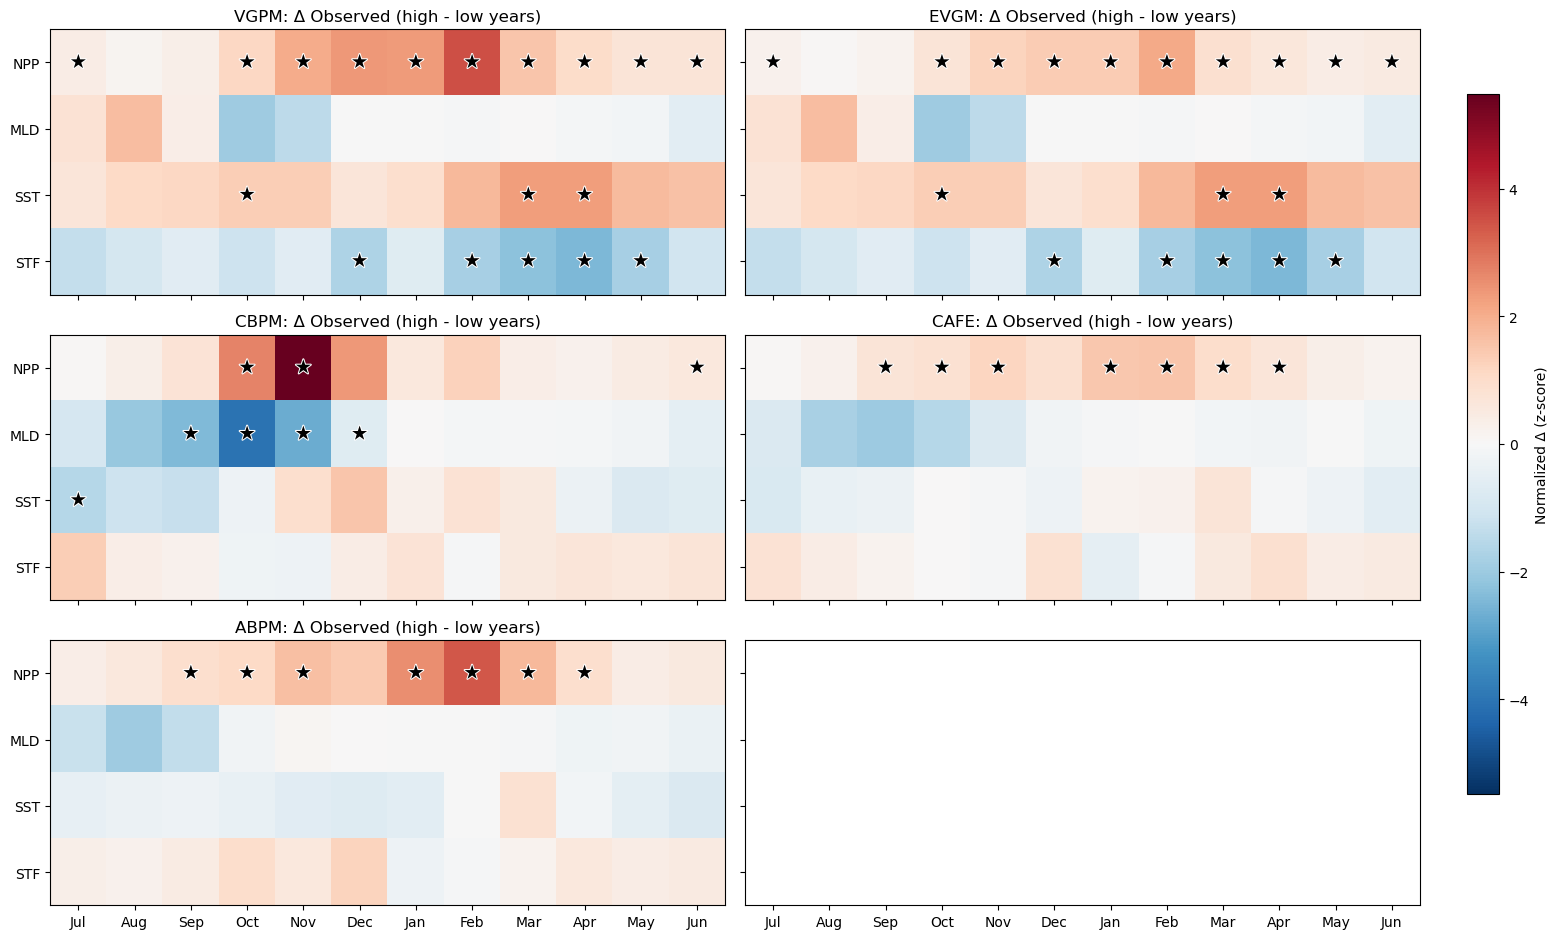

In [63]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
import calendar

df = df_bootstrap

# --- 1. Setup ---
groups_to_plot = ['vgpm', 'evgm', 'cbpm', 'cafe', 'abpm']  # Updated groups
group_labels = ['vgpm', 'evpgm', 'cbpm', 'cafe', 'abpm']
variable_order = ['NPP', 'MLD', 'SST', 'STF']       # Your variables
month_order = list(range(7, 13)) + list(range(1, 7))  # July to June
n_rows, n_cols = 3, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 10), sharex=True, sharey=True)

# Global colormap scaling
vmax = np.nanmax(np.abs(df['delta_norm']))
vmin = -vmax
cmap = plt.get_cmap('RdBu_r')

# --- 2. Plot each group ---
for idx, group in enumerate(groups_to_plot):
    ax = axes[idx // n_cols, idx % n_cols]
    
    # Subset and pivot
    df_group = df[df['group'] == group]
    data = df_group.pivot(index='month', columns='variable', values='delta_norm') \
                   .reindex(index=month_order, columns=variable_order)
    sig = df_group.pivot(index='month', columns='variable', values='p_val') < 0.05
    sig = sig.reindex(index=month_order, columns=variable_order)

    data_T = data.T.values  # shape: (variables, months)
    sig_T = sig.T.values

    im = ax.imshow(data_T, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')

    # Ticks and labels
    ax.set_xticks(np.arange(12))
    ax.set_xticklabels([calendar.month_abbr[m] for m in month_order])
    ax.set_yticks(np.arange(len(variable_order)))
    ax.set_yticklabels(variable_order)
    ax.set_title(f"{group.upper()}: Δ Observed (high - low years)")

    # Add stippling for p < 0.05
    for i in range(len(variable_order)):
        for j in range(12):
            if sig_T[i, j]:
                ax.text(j, i, '★', ha='center', va='center', color='black', fontsize = 14,
                        path_effects=[pe.withStroke(linewidth=1.5, foreground='white')])

# --- 3. Shared Colorbar ---
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Normalized Δ (z-score)")

# Layout
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


### Figure 2: Plot

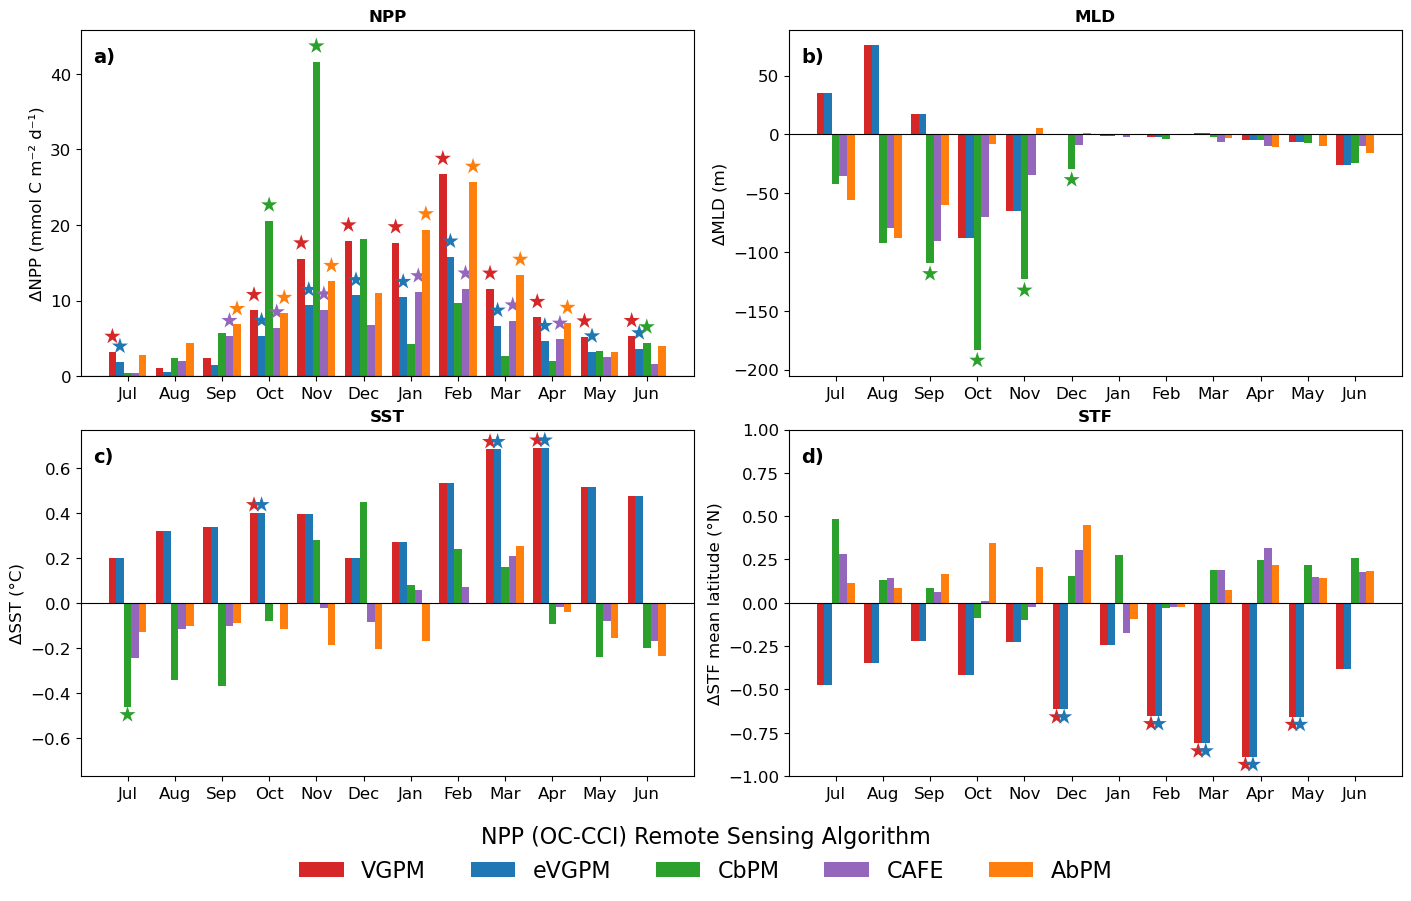

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# --- Setup ---
npp_models = ['vgpm', 'evgm', 'cbpm', 'cafe', 'abpm']  # These are your group names
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple', 'tab:orange']
color_map = dict(zip(npp_models, colors))

signif_threshold = 0.05
groups = npp_models
variables = df['variable'].unique()

bar_width = 0.8 / len(groups)
months_orig = np.arange(1, 13)

def circshift_months(df_var, shift=6):
    shifted_months = ((months_orig - 1 + shift) % 12) + 1
    month_map = dict(zip(months_orig, shifted_months))
    df_var = df_var.copy()
    df_var['month_shifted'] = df_var['month'].map(month_map)
    return df_var.sort_values('month_shifted')

units_map = {
    'NPP': 'ΔNPP (mmol C m⁻² d⁻¹)',
    'MLD': 'ΔMLD (m)',
    'SST': 'ΔSST (°C)',
    'STF': 'ΔSTF mean latitude (°N)',
    # Add more as needed
}

# --- Plot ---
fig, axs = plt.subplots(2, 2, figsize=(14, 8), constrained_layout=True)
axs = axs.flatten()


for i, ax in enumerate(axs):
    ax.text(
        0.02, 0.95,
        f"{string.ascii_lowercase[i]})",
        transform=ax.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top'
    )

for i, var_to_plot in enumerate(variables):
    ax = axs[i]
    df_var = df[df['variable'] == var_to_plot]
    df_var = circshift_months(df_var, shift=6)
    x = np.arange(1, 13)

    for j, group in enumerate(groups):
        group_data = df_var[df_var['group'] == group].sort_values('month_shifted')
        if group_data.empty:
            continue
        positions = x - 0.4 + j * bar_width + bar_width / 2

        color = color_map.get(group, 'grey')

        ax.bar(
            positions,
            group_data['delta_obs'],
            width=bar_width,
            label=group.upper() if i == 0 else "",
            color=color,
            edgecolor='none'
        )

        # Add significance stars
        for pos, (_, row) in zip(positions, group_data.iterrows()):
            if row['p_val'] < signif_threshold:
                y = row['delta_obs']
                offset = 0.05 * max(abs(df_var['delta_obs']))
                star_y = y + (offset if y >= 0 else -offset)
                ax.scatter(
                    pos, star_y, marker='*', s=150,
                    color=color,
                    edgecolors='none', linewidth=0.8
                )

    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'], fontsize = 12)
    ax.tick_params(axis='y', labelsize=12)
    #ax.set_xlabel('Month')
    ax.set_ylabel(units_map.get(var_to_plot, f'Δ {var_to_plot}'), fontsize = 12)
    ax.set_title(var_to_plot, fontweight='bold', fontsize = 12)

# Remove unused subplots
for k in range(len(variables), len(axs)):
    fig.delaxes(axs[k])

group_labels = ['VGPM', 'eVGPM', 'CbPM', 'CAFE', 'AbPM']
# Add shared legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, group_labels, title='NPP (OC-CCI) Remote Sensing Algorithm', title_fontsize=16,
           loc='upper center', ncol=5, fontsize=16, bbox_to_anchor=(0.5, 0), edgecolor = 'none')

# centre axes by pnale specifics 
axs[2].set_ylim([-0.77,0.77])
axs[3].set_ylim([-1,1])

plt.show()


# Figure 8:

## Figure 8a:  Plot spatially averaged, deseasonalised and smoothed trend

/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_5771/224073748.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]
/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_5771/224073748.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval = model.pvalues[1]
/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_5771/224073748.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slop

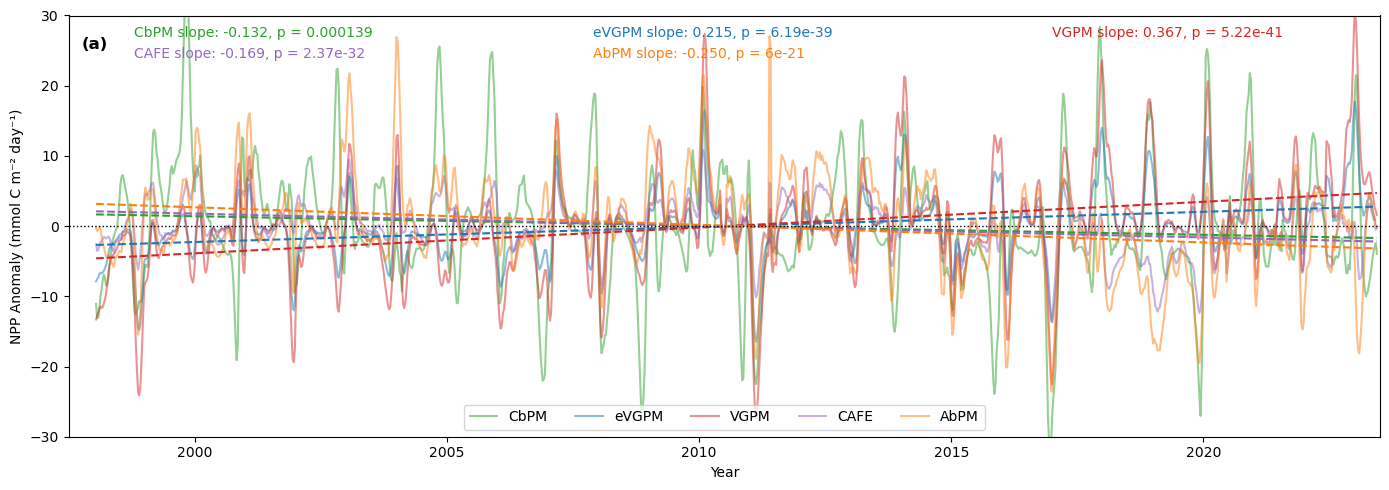

In [65]:
import statsmodels.api as sm

# Define weights based on cosine of latitude
weights = np.cos(np.deg2rad(NPP_VGPM_OCCCI_subset.lat))
weights.name = "weights"

NPP_CbPM_OCCCI_subset_avg = NPP_CbPM_OCCCI_subset['Westberry-CbPM'].weighted(weights).mean(dim = ['lat', 'lon'])
NPP_eVGPM_OCCCI_subset_avg = NPP_eVGPM_OCCCI_subset['Eppley-VGPM'].weighted(weights).mean(dim = ['lat', 'lon'])
NPP_VGPM_OCCCI_subset_avg = NPP_VGPM_OCCCI_subset['Behrenfeld-VGPM'].weighted(weights).mean(dim = ['lat', 'lon'])
NPP_CAFE_OCCCI_subset_avg = NPP_CAFE_OCCCI_subset['Silsbe-CAFE'].weighted(weights).mean(dim = ['lat', 'lon'])
NPP_AbPM_OCCCI_subset_avg = NPP_AbPM_OCCCI_subset['Lee-AbPM'].weighted(weights).mean(dim = ['lat', 'lon'])

# Step 1: Convert time to day-of-year group
doy = NPP_CbPM_OCCCI_subset_avg['time'].dt.dayofyear

# Step 2: Compute climatological mean for each 8-day bin
cbpm_clim = NPP_CbPM_OCCCI_subset['Westberry-CbPM'].groupby(doy).mean('time')
evgpm_clim = NPP_eVGPM_OCCCI_subset['Eppley-VGPM'].groupby(doy).mean('time')
vgpm_clim = NPP_VGPM_OCCCI_subset['Behrenfeld-VGPM'].groupby(doy).mean('time')
cafe_clim = NPP_CAFE_OCCCI_subset['Silsbe-CAFE'].groupby(doy).mean('time')
abpm_clim = NPP_AbPM_OCCCI_subset['Lee-AbPM'].groupby(doy).mean('time')

# Step 3: Subtract climatology to get anomalies
cbpm_anom = NPP_CbPM_OCCCI_subset['Westberry-CbPM'].groupby(doy) - cbpm_clim
evgpm_anom = NPP_eVGPM_OCCCI_subset['Eppley-VGPM'].groupby(doy) - evgpm_clim
vgpm_anom = NPP_VGPM_OCCCI_subset['Behrenfeld-VGPM'].groupby(doy) - vgpm_clim
cafe_anom = NPP_CAFE_OCCCI_subset['Silsbe-CAFE'].groupby(doy) - cafe_clim
abpm_anom = NPP_AbPM_OCCCI_subset['Lee-AbPM'].groupby(doy) - abpm_clim

cbpm_anom_avg = cbpm_anom.weighted(weights).mean(dim = ['lat', 'lon'])
evgpm_anom_avg = evgpm_anom.weighted(weights).mean(dim = ['lat', 'lon'])
vgpm_anom_avg = vgpm_anom.weighted(weights).mean(dim = ['lat', 'lon'])
cafe_anom_avg = cafe_anom.weighted(weights).mean(dim = ['lat', 'lon'])
abpm_anom_avg = abpm_anom.weighted(weights).mean(dim = ['lat', 'lon'])

# Steo 4: Apply 4-timestep rolling mean (centered)
cbpm_anom_smooth = cbpm_anom.rolling(time=5, center=True).mean()
evgpm_anom_smooth = evgpm_anom.rolling(time=5, center=True).mean()
vgpm_anom_smooth = vgpm_anom.rolling(time=5, center=True).mean()
cafe_anom_smooth = cafe_anom.rolling(time=5, center=True).mean()
abpm_anom_smooth = abpm_anom.rolling(time=5, center=True).mean()

cbpm_anom_smooth_avg = cbpm_anom_smooth.mean(dim = ['lat', 'lon'])
evgpm_anom_smooth_avg = evgpm_anom_smooth.mean(dim = ['lat', 'lon'])
vgpm_anom_smooth_avg = vgpm_anom_smooth.mean(dim = ['lat', 'lon'])
cafe_anom_smooth_avg = cafe_anom_smooth.mean(dim = ['lat', 'lon'])
abpm_anom_smooth_avg = abpm_anom_smooth.mean(dim = ['lat', 'lon'])

# 1. Convert time to fractional years
def time_to_fractional_years(time):
    year = time.dt.year
    day_of_year = time.dt.dayofyear
    is_leap = (year % 4 == 0) & ((year % 100 != 0) | (year % 400 == 0))
    days_in_year = xr.where(is_leap, 366, 365)
    return year + (day_of_year - 1) / days_in_year

# Convert to fractional year array
time_frac = time_to_fractional_years(cbpm_anom_smooth_avg['time'])

# 2. Prepare a helper function to run OLS
def fit_trend(anom, time_frac):
    df = pd.DataFrame({'anom': anom.values, 'time': time_frac.values})
    df = df.dropna()
    X = sm.add_constant(df['time'])
    model = sm.OLS(df['anom'], X).fit()
    return model, df['time'], df['anom']

# Fit models (no smoothing)
#model_cbpm, t_cbpm, y_cbpm = fit_trend(cbpm_anom, time_frac)
#model_evgpm, t_evgpm, y_evgpm = fit_trend(evgpm_anom, time_frac)
#model_vgpm, t_vgpm, y_vgpm = fit_trend(vgpm_anom, time_frac)
#model_cafe, t_cafe, y_cafe = fit_trend(cafe_anom, time_frac)

# Fit models using the smoothed anomalies
model_cbpm, t_cbpm, y_cbpm = fit_trend(cbpm_anom_smooth_avg, time_frac)
model_evgpm, t_evgpm, y_evgpm = fit_trend(evgpm_anom_smooth_avg, time_frac)
model_vgpm, t_vgpm, y_vgpm = fit_trend(vgpm_anom_smooth_avg, time_frac)
model_cafe, t_cafe, y_cafe = fit_trend(cafe_anom_smooth_avg, time_frac)
model_abpm, t_abpm, y_abpm = fit_trend(abpm_anom_smooth_avg, time_frac)

# 3. Plot
fig, ax = plt.subplots(figsize=(14, 5))

# Plot anomalies
ax.plot(t_cbpm, y_cbpm/12.011, label='CbPM', color='tab:green', alpha=0.5)
ax.plot(t_evgpm, y_evgpm/12.011, label='eVGPM', color='tab:blue', alpha=0.5)
ax.plot(t_vgpm, y_vgpm/12.011, label='VGPM', color='tab:red', alpha=0.5)
ax.plot(t_cafe, y_cafe/12.011, label='CAFE', color='tab:purple', alpha=0.5)
ax.plot(t_abpm, y_abpm/12.011, label='AbPM', color='tab:orange', alpha=0.5)

# Plot trend lines
ax.plot(t_cbpm, model_cbpm.predict(sm.add_constant(t_cbpm))/12.011, '--', color='tab:green')
ax.plot(t_evgpm, model_evgpm.predict(sm.add_constant(t_evgpm))/12.011, '--', color='tab:blue')
ax.plot(t_vgpm, model_vgpm.predict(sm.add_constant(t_vgpm))/12.011, '--', color='tab:red')
ax.plot(t_cafe, model_cafe.predict(sm.add_constant(t_cafe))/12.011, '--', color='tab:purple')
ax.plot(t_abpm, model_abpm.predict(sm.add_constant(t_abpm))/12.011, '--', color='tab:orange')

# Add legend and labels
#ax.set_title('Deseasonalised NPP Time Series with Linear Trends')
ax.set_ylabel('NPP Anomaly (mmol C m⁻² day⁻¹)')
ax.set_xlabel('Year')
ax.axhline(0, color='black', linestyle=':', linewidth=1)
ax.legend(ncol = 5, loc = 'lower center')
ax.set_ylim(-30,30)
ax.set_xlim(1997.5,2023.5)

model_list = [model_cbpm, model_evgpm, model_vgpm, model_cafe, model_abpm]
names = ['CbPM', 'eVGPM', 'VGPM', 'CAFE', 'AbPM']
colors = ['tab:green', 'tab:blue','tab:red', 'tab:purple', 'tab:orange']

# Loop to annotate
for i, (name, model, color) in enumerate(zip(names, model_list, colors)):
    slope = model.params[1]
    pval = model.pvalues[1]
    
    # Compute position dynamically (two per row)
    row = i // 3
    col = i % 3
    x = 0.05 + col * 0.35
    y = 0.95 - row * 0.05
    
    ax.text(x, y, f'{name} slope: {slope/12.011:.3f}, p = {pval:.3g}', 
             transform=ax.transAxes, color=color, fontsize=10)
    
import string
panel_label = f"({string.ascii_lowercase[0]})"
ax.text(0.01, 0.95, panel_label, transform=ax.transAxes,
             fontsize=12, fontweight='bold', va='top', ha='left')


plt.tight_layout()
plt.show()

## Figure 8b - e: Pixel-wise regressions of NPP trends. 
This section sequentially processes each dataset and each pixel and is slow. See section 6.2 for a Dask parallelized option

In [10]:
# These lat/lon boundaries have different handles to differentiate them from the analysis window set at the start of this notebook. These values are for the areal extent of the pixelwise regressions. 
minlon, maxlon = 135, 155
minlat, maxlat = -50, -40

NPP_VGPM_OCCCI = xr.open_dataset('OC_CCI_NPP_algorithms/1998_2024_NPP_BEHRENFELD_VGPM_25KM_8D.nc')
NPP_VGPM_OCCCI_mapsubset = NPP_VGPM_OCCCI.sel(lat=slice(minlat, maxlat), lon=slice(minlon, maxlon))
NPP_VGPM_OCCCI.close()
del NPP_VGPM_OCCCI

NPP_eVGPM_OCCCI = xr.open_dataset('OC_CCI_NPP_algorithms/1998_2024_NPP_EPPLEY_VGPM_25KM_8D.nc')
NPP_eVGPM_OCCCI_mapsubset = NPP_eVGPM_OCCCI.sel(lat=slice(minlat, maxlat), lon=slice(minlon, maxlon))
NPP_eVGPM_OCCCI.close()
del NPP_eVGPM_OCCCI

NPP_CAFE_OCCCI = xr.open_dataset('OC_CCI_NPP_algorithms/1998_2024_NPP_SILSBE_CAFE_25KM_8D.nc')
NPP_CAFE_OCCCI_mapsubset = NPP_CAFE_OCCCI.sel(lat=slice(minlat, maxlat), lon=slice(minlon, maxlon))
NPP_CAFE_OCCCI.close()
del NPP_CAFE_OCCCI

NPP_CbPM_OCCCI = xr.open_dataset('OC_CCI_NPP_algorithms/1998_2024_NPP_WESTBERRY_CBPM_25KM_8D.nc')
NPP_CbPM_OCCCI_mapsubset = NPP_CbPM_OCCCI.sel(lat=slice(minlat, maxlat), lon=slice(minlon, maxlon))
NPP_CbPM_OCCCI.close()
del NPP_CbPM_OCCCI

NPP_AbPM_OCCCI = xr.open_dataset('OC_CCI_NPP_algorithms/1998_2024_NPP_LEE_ABPM_25KM_8D.nc')
NPP_AbPM_OCCCI_mapsubset = NPP_AbPM_OCCCI.sel(lat=slice(minlat, maxlat), lon=slice(minlon, maxlon))
NPP_AbPM_OCCCI.close()
del NPP_AbPM_OCCCI

print('Subsetting complete, full domains removed from memory')

Subsetting complete, full domains removed from memory


### Option 1: sequential processing

In [13]:
from tqdm import tqdm
import statsmodels.api as sm
def deseasonalise_pixelwise(da, time_dim='time'):
    doy = da[time_dim].dt.dayofyear
    clim = da.groupby(doy).mean(dim=time_dim)
    anomalies = da.groupby(doy) - clim
    return anomalies

def compute_pixelwise_trend_with_progress(da_anom, time_dim='time'):
    # Convert time to fractional years since start
    time_nums = (da_anom[time_dim] - da_anom[time_dim][0]) / np.timedelta64(1, 'D')
    time_nums = time_nums.astype(float) / 365.25

    lat = da_anom['lat']
    lon = da_anom['lon']
    trend_array = np.full((len(lat), len(lon)), np.nan)
    pval_array = np.full((len(lat), len(lon)), np.nan)

    for i in tqdm(range(len(lat)), desc='Processing latitudes'):
        for j in range(len(lon)):
            y = da_anom[:, i, j].values
            mask = np.isfinite(y)
            if np.sum(mask) >= 10:
                X = sm.add_constant(time_nums[mask])
                model = sm.OLS(y[mask], X).fit()
                trend_array[i, j] = model.params[1]
                pval_array[i, j] = model.pvalues[1]

    trend = xr.DataArray(trend_array, coords=[lat, lon], dims=['lat', 'lon'], name='trend')
    pval = xr.DataArray(pval_array, coords=[lat, lon], dims=['lat', 'lon'], name='pval')
    return trend, pval

def create_land_mask(da, time_dim='time', threshold=0.9):
    nan_frac = da.isnull().sum(dim=time_dim) / da.sizes[time_dim]
    return nan_frac > threshold  # True where we want to mask (i.e., land)

def preprocess_npp_for_trend_analysis(dataset_dict, time_dim='time'):
    results = {}
    
    # 👉 Add tqdm around the name loop
    for name in tqdm(dataset_dict.keys(), desc="Datasets"):
        da = dataset_dict[name]
        print(f"\nProcessing: {name}")
        
        anom = deseasonalise_pixelwise(da, time_dim=time_dim)
        trend, pval = compute_pixelwise_trend_with_progress(anom, time_dim=time_dim)
        
        land_mask = create_land_mask(da, time_dim=time_dim)
        trend = trend.where(~land_mask)
        pval = pval.where(~land_mask)
        
        results[name] = {'trend': trend, 'pval': pval}
    
    return results

In [ ]:
## Apply functions to dataset subsets: 
dataset_dict = {
    'Westberry-CbPM': NPP_CbPM_OCCCI_mapsubset['Westberry-CbPM'],
    'Eppley-VGPM': NPP_eVGPM_OCCCI_mapsubset['Eppley-VGPM'],
    'Behrenfeld-VGPM': NPP_VGPM_OCCCI_mapsubset['Behrenfeld-VGPM'],
    'Silsbe-CAFE': NPP_CAFE_OCCCI_mapsubset['Silsbe-CAFE'],
    'Lee-AbPM': NPP_AbPM_OCCCI_mapsubset['Lee-AbPM']
}

preprocessed_results = preprocess_npp_for_trend_analysis(dataset_dict)

In [35]:
import string
def plot_npp_trends_from_results(results, titles=None, cmap='RdBu_r', sig_level=0.05):
    n = len(results)
    fig = plt.figure(figsize=(20, 10))
    
    # Create grid layout manually (3 rows, 2 columns)
    gs = fig.add_gridspec(3, 2)
    axes = []

       # Create the first 4 subplots in a 2x2 grid
    for i in range(4):
        ax = fig.add_subplot(gs[i // 2, i % 2], projection=ccrs.PlateCarree())
        axes.append(ax)

    # Manually add the 5th subplot centered below
    # Define axis dimensions: [left, bottom, width, height]
    # These values are fractions of the figure width/height
    ax5 = fig.add_axes([0.25, 0.0, 0.5, 0.3], projection=ccrs.PlateCarree())
    axes.append(ax5)

    for i, (name, res) in enumerate(results.items()):
        ax = axes[i]
        trend = res['trend'] / 12.011
        pval = res['pval']
        title = titles[i] if titles else name

        panel_label = f"({string.ascii_lowercase[i+1]})"
        ax.text(0.01, 1.1, panel_label, transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top', ha='left')

        im = trend.plot(
            ax=ax,
            cmap=cmap,
            transform=ccrs.PlateCarree(),
            vmin=-1,
            vmax=1,
            cbar_kwargs={'label': 'NPP trend (mmol C m$^{-2}$ yr$^{-1}$)', 'extend': 'both', 'fraction': 0.02}
        )

        ax.coastlines()
        ax.set_title(title)
        ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor='lightgray')
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.5, color='gray', alpha=0.5, linestyle=':')
        gl.top_labels = False
        gl.right_labels = False

        # Bounding box
        boxlon_min, boxlon_max = 140, 150
        boxlat_min, boxlat_max = -49, -45
        ax.plot(
            [boxlon_min, boxlon_max, boxlon_max, boxlon_min, boxlon_min],
            [boxlat_min, boxlat_min, boxlat_max, boxlat_max, boxlat_min],
            color='black', linestyle='-', linewidth=1
        )

        # Stippling
        sig_mask = (pval < sig_level)
        y, x = np.where(sig_mask)
        lats = trend['lat'].values[y]
        lons = trend['lon'].values[x]
        ax.plot(lons, lats, 'k.', markersize=0.5, transform=ccrs.PlateCarree())

    plt.tight_layout()
    plt.show()


/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_1075/3745294672.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


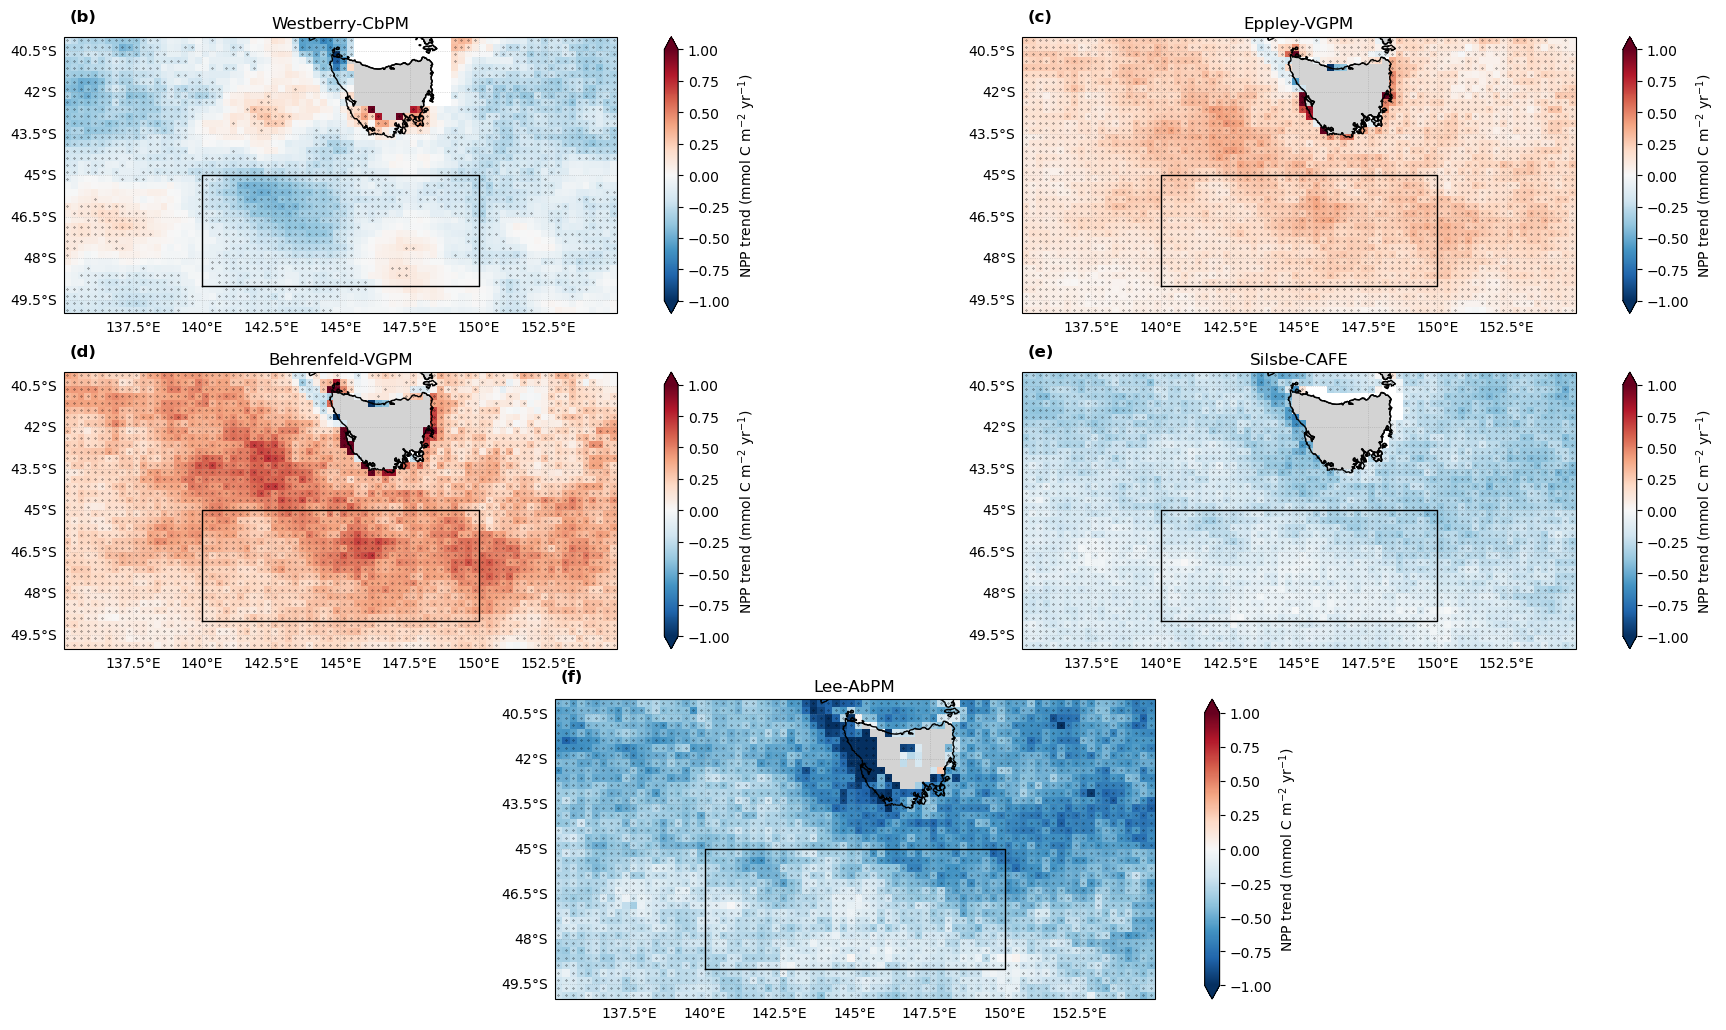

In [44]:
plot_npp_trends_from_results(preprocessed_results, titles=[
    'Westberry-CbPM',
    'Eppley-VGPM',
    'Behrenfeld-VGPM',
    'Silsbe-CAFE',
    'Lee-AbPM'
])

### Option 2: Dask Parallelised processing: 

In [31]:
import xarray as xr
import dask.array as da
from dask.diagnostics import ProgressBar

minlon, maxlon = 135, 155
minlat, maxlat = -50, -40

def open_subset(path, var):
    ds = xr.open_dataset(path, chunks={"time": 50, "lat": 50, "lon": 50})
    return ds[var].sel(lat=slice(minlat, maxlat), lon=slice(minlon, maxlon))

In [32]:
dataset_dict = {
    'Westberry-CbPM': open_subset(
        'OC_CCI_NPP_algorithms/1998_2024_NPP_WESTBERRY_CBPM_25KM_8D.nc',
        'Westberry-CbPM'
    ),
    'Eppley-VGPM': open_subset(
        'OC_CCI_NPP_algorithms/1998_2024_NPP_EPPLEY_VGPM_25KM_8D.nc',
        'Eppley-VGPM'
    ),
    'Behrenfeld-VGPM': open_subset(
        'OC_CCI_NPP_algorithms/1998_2024_NPP_BEHRENFELD_VGPM_25KM_8D.nc',
        'Behrenfeld-VGPM'
    ),
    'Silsbe-CAFE': open_subset(
        'OC_CCI_NPP_algorithms/1998_2024_NPP_SILSBE_CAFE_25KM_8D.nc',
        'Silsbe-CAFE'
    ),
    'Lee-AbPM': open_subset(
        'OC_CCI_NPP_algorithms/1998_2024_NPP_LEE_ABPM_25KM_8D.nc',
        'Lee-AbPM'
    )
}

print("Lazy-loaded 5 datasets with Dask chunking.")

Lazy-loaded 5 datasets with Dask chunking.


/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_1075/954410540.py:9: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(path, chunks={"time": 50, "lat": 50, "lon": 50})
/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_1075/954410540.py:9: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(path, chunks={"time": 50, "lat": 50, "lon": 50})
/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_1075/954410540.py:9: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(path, chunks={"time": 50, "lat": 50, "lon": 50})


In [33]:
def deseasonalise_pixelwise(da, time_dim='time'):
    doy = da[time_dim].dt.dayofyear
    clim = da.groupby(doy).mean(dim=time_dim)
    return da.groupby(doy) - clim

In [38]:
import statsmodels.api as sm
def ols_trend(y, t):
    mask = np.isfinite(y)
    if mask.sum() < 10:
        return np.nan, np.nan
    X = sm.add_constant(t[mask])
    model = sm.OLS(y[mask], X).fit()
    return model.params[1], model.pvalues[1]

def compute_trend_da(da_anom, time_dim="time"):

    # Time in fractional years (stay as DataArray)
    t = (da_anom[time_dim] - da_anom[time_dim][0]) / np.timedelta64(1, "D")
    t = t.astype(float) / 365.25     # KEEP AS DATAARRAY, DO NOT USE .values

    trend, pval = xr.apply_ufunc(
        ols_trend,
        da_anom,
        t,
        input_core_dims=[[time_dim], [time_dim]],
        output_core_dims=[[], []],
        dask="parallelized",
        vectorize=True,
        output_dtypes=[float, float],
        dask_gufunc_kwargs={"allow_rechunk": True}
    )
    return trend, pval

In [39]:
def create_land_mask(da, time_dim='time', threshold=0.9):
    nan_frac = da.isnull().sum(dim=time_dim) / da.sizes[time_dim]
    return nan_frac > threshold

In [40]:
def preprocess_npp_for_trend_analysis(dataset_dict, time_dim='time'):
    results = {}

    for name, da in dataset_dict.items():
        print(f"Processing: {name}")

        # IMPORTANT: regression requires time dim fully in memory
        da = da.chunk({time_dim: -1})

        anom = deseasonalise_pixelwise(da, time_dim=time_dim)
        anom = anom.chunk({time_dim: -1})   # also chunk anomalies

        trend, pval = compute_trend_da(anom, time_dim=time_dim)

        land_mask = create_land_mask(da, time_dim=time_dim)
        trend = trend.where(~land_mask)
        pval = pval.where(~land_mask)

        results[name] = {"trend": trend, "pval": pval}

    return results

In [41]:
with ProgressBar():
    preprocessed_results = preprocess_npp_for_trend_analysis(dataset_dict)
    # forces compute for all datasets
    preprocessed_results = {
        name: {k: v.compute() for k, v in res.items()}
        for name, res in preprocessed_results.items()
    }

Processing: Westberry-CbPM
[########################################] | 100% Completed | 106.08 ms
[########################################] | 100% Completed | 106.50 ms
Processing: Eppley-VGPM
[########################################] | 100% Completed | 105.93 ms
[########################################] | 100% Completed | 107.16 ms
Processing: Behrenfeld-VGPM
[########################################] | 100% Completed | 106.42 ms
[########################################] | 100% Completed | 109.82 ms
Processing: Silsbe-CAFE
[########################################] | 100% Completed | 105.98 ms
[########################################] | 100% Completed | 106.50 ms
Processing: Lee-AbPM
[########################################] | 100% Completed | 106.19 ms
[########################################] | 100% Completed | 103.14 ms
[########################################] | 100% Completed | 9.01 ss
[########################################] | 100% Completed | 8.43 ss
[###############

In [42]:
import string
def plot_npp_trends_from_results(results, titles=None, cmap='RdBu_r', sig_level=0.05):
    n = len(results)
    fig = plt.figure(figsize=(20, 10))
    
    # Create grid layout manually (3 rows, 2 columns)
    gs = fig.add_gridspec(3, 2)
    axes = []

       # Create the first 4 subplots in a 2x2 grid
    for i in range(4):
        ax = fig.add_subplot(gs[i // 2, i % 2], projection=ccrs.PlateCarree())
        axes.append(ax)

    # Manually add the 5th subplot centered below
    # Define axis dimensions: [left, bottom, width, height]
    # These values are fractions of the figure width/height
    ax5 = fig.add_axes([0.25, 0.0, 0.5, 0.3], projection=ccrs.PlateCarree())
    axes.append(ax5)

    for i, (name, res) in enumerate(results.items()):
        ax = axes[i]
        trend = res['trend'] / 12.011
        pval = res['pval']
        title = titles[i] if titles else name

        panel_label = f"({string.ascii_lowercase[i+1]})"
        ax.text(0.01, 1.1, panel_label, transform=ax.transAxes,
                fontsize=12, fontweight='bold', va='top', ha='left')

        im = trend.plot(
            ax=ax,
            cmap=cmap,
            transform=ccrs.PlateCarree(),
            vmin=-1,
            vmax=1,
            cbar_kwargs={'label': 'NPP trend (mmol C m$^{-2}$ yr$^{-1}$)', 'extend': 'both', 'fraction': 0.02}
        )

        ax.coastlines()
        ax.set_title(title)
        ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor='lightgray')
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.5, color='gray', alpha=0.5, linestyle=':')
        gl.top_labels = False
        gl.right_labels = False

        # Bounding box
        boxlon_min, boxlon_max = 140, 150
        boxlat_min, boxlat_max = -49, -45
        ax.plot(
            [boxlon_min, boxlon_max, boxlon_max, boxlon_min, boxlon_min],
            [boxlat_min, boxlat_min, boxlat_max, boxlat_max, boxlat_min],
            color='black', linestyle='-', linewidth=1
        )

        # Stippling
        sig_mask = (pval < sig_level)
        y, x = np.where(sig_mask)
        lats = trend['lat'].values[y]
        lons = trend['lon'].values[x]
        ax.plot(lons, lats, 'k.', markersize=0.5, transform=ccrs.PlateCarree())

    plt.tight_layout()
    plt.show()


/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_1075/3745294672.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


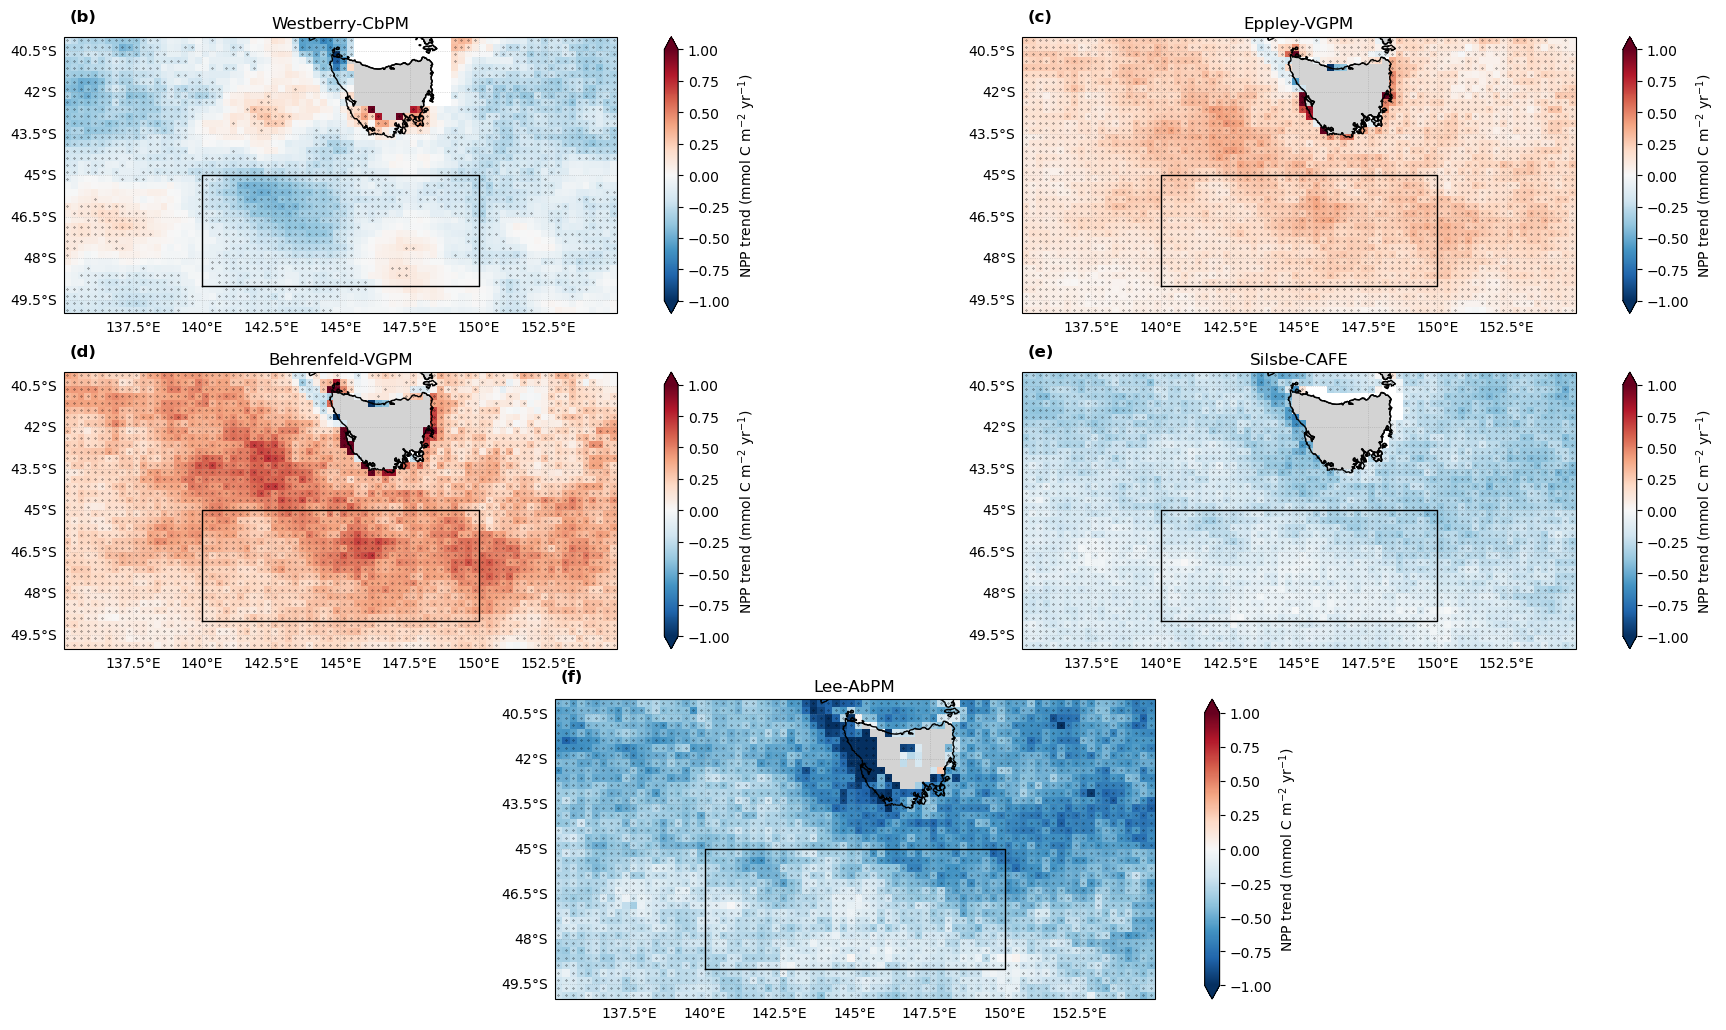

In [43]:
plot_npp_trends_from_results(preprocessed_results, titles=[
    'Westberry-CbPM',
    'Eppley-VGPM',
    'Behrenfeld-VGPM',
    'Silsbe-CAFE',
    'Lee-AbPM'
])